# Abstract:
In this study, AutoML (utilizing H2O) is applied to analyze World Happiness Data. The exploration begins by intentionally introducing mistakes to underscore the significance of validating output. Comprehensive explanations of both output and code are provided. The initial assessments involve the GLM and GBM methods, followed by an application of AutoML for a holistic analysis.



# About Data

In [1]:
!pip install h2o
%matplotlib inline
import random, os, sys
import h2o
import pandas
import pprint
import operator
import matplotlib
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293968 sha256=c31e9be534e38217e4aac88a31292c1401f7488f831833ad5bdee1a7df82858d
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


In [2]:
import pandas as pd
import seaborn as sns

## Correlation of Dataset (For later reference)

Check Life Expectancy Row Carefully !!

<ipython-input-3-6215ba60b0a6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_for_corr.corr(),annot=True)


<Axes: >

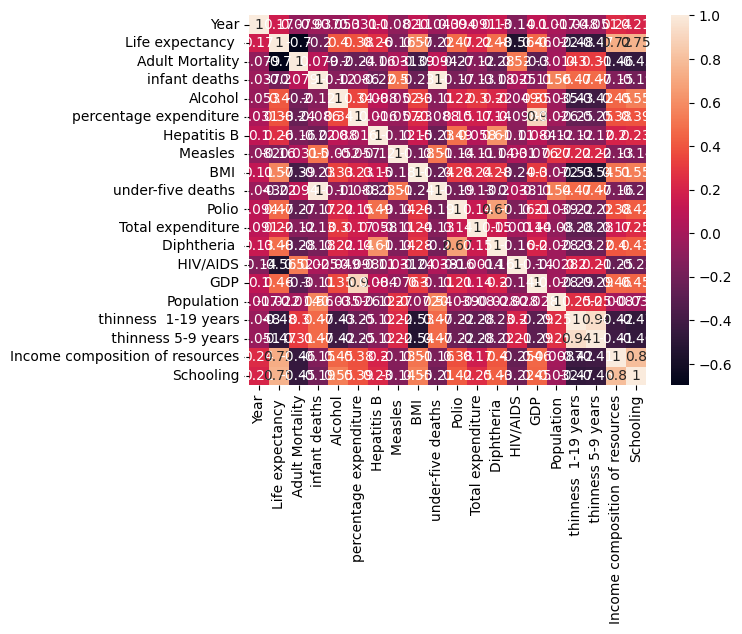

In [3]:
data_for_corr = pd.read_csv( 'https://raw.githubusercontent.com/KhanAyasha/002697806_DSEM_assignments-/main/Life%20Expectancy%20Data.csv?token=GHSAT0AAAAAACM3AGAIUVCAHITZHW3NFT2EZOT6E5Q' )
sns.heatmap(data_for_corr.corr(),annot=True)

In [6]:
data_for_corr

Country  Year      Status  Life expectancy   Adult Mortality  \
0     Afghanistan  2015  Developing              65.0            263.0   
1     Afghanistan  2014  Developing              59.9            271.0   
2     Afghanistan  2013  Developing              59.9            268.0   
3     Afghanistan  2012  Developing              59.5            272.0   
4     Afghanistan  2011  Developing              59.2            275.0   
...           ...   ...         ...               ...              ...   
2933     Zimbabwe  2004  Developing              44.3            723.0   
2934     Zimbabwe  2003  Developing              44.5            715.0   
2935     Zimbabwe  2002  Developing              44.8             73.0   
2936     Zimbabwe  2001  Developing              45.3            686.0   
2937     Zimbabwe  2000  Developing              46.0            665.0   

      infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   \
0                62     0.01               71.279624         65.0      1154   
1                64     0.01               73.523582         62.0       492   
2                66     0.01               73.219243         64.0       430   
3                69     0.01               78.184215         67.0      2787   
4                71     0.01                7.097109         68.0      3013   
...             ...      ...                     ...          ...       ...   
2933             27     4.36                0.000000         68.0        31   
2934             26     4.06                0.000000          7.0       998   
2935             25     4.43                0.000000         73.0       304   
2936             25     1.72                0.000000         76.0       529   
2937             24     1.68                0.000000         79.0      1483   

      ...  Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  \
0     ...    6.0               8.16         65.0        0.1  584.259210   
1     ...   58.0               8.18         62.0        0.1  612.696514   
2     ...   62.0               8.13         64.0        0.1  631.744976   
3     ...   67.0               8.52         67.0        0.1  669.959000   
4     ...   68.0               7.87         68.0        0.1   63.537231   
...   ...    ...                ...          ...        ...         ...   
2933  ...   67.0               7.13         65.0       33.6  454.366654   
2934  ...    7.0               6.52         68.0       36.7  453.351155   
2935  ...   73.0               6.53         71.0       39.8   57.348340   
2936  ...   76.0               6.16         75.0       42.1  548.587312   
2937  ...   78.0               7.10         78.0       43.5  547.358878   

      Population   thinness  1-19 years   thinness 5-9 years  \
0     33736494.0                   17.2                 17.3   
1       327582.0                   17.5                 17.5   
2     31731688.0                   17.7                 17.7   
3      3696958.0                   17.9                 18.0   
4      2978599.0                   18.2                 18.2   
...          ...                    ...                  ...   
2933  12777511.0                    9.4                  9.4   
2934  12633897.0                    9.8                  9.9   
2935    125525.0                    1.2                  1.3   
2936  12366165.0                    1.6                  1.7   
2937  12222251.0                   11.0                 11.2   

      Income composition of resources  Schooling  
0                               0.479       10.1  
1                               0.476       10.0  
2                               0.470        9.9  
3                               0.463        9.8  
4                               0.454        9.5  
...                               ...        ...  
2933                            0.407        9.2  
2934                            0.418        9.5  
2935                            0.427      

## H2O starts
Init is used to initialize H2O library.

strict_version_check : If True, an error will be raised if the client and server versions don’t match.

In [7]:
#Connect to a cluster or initialize it if not started
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmply_9hyc7
  JVM stdout: /tmp/tmply_9hyc7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmply_9hyc7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.3
H2O_cluster_version_age:    1 month and 30 days
H2O_cluster_name:           H2O_from_python_unknownUser_luylmz
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [8]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

In [9]:
## Please check we are importing dataset with H2O and not Pandas
data = h2o.import_file( 'https://raw.githubusercontent.com/KhanAyasha/002697806_DSEM_assignments-/main/Life%20Expectancy%20Data.csv?token=GHSAT0AAAAAACM3AGAIUVCAHITZHW3NFT2EZOT6E5Q' )

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [10]:
data.describe()

Rows:2938
Cols:22

Country      Year                Status      Life expectancy     Adult Mortality     infant deaths       Alcohol            percentage expenditure    Hepatitis B        Measles            BMI                 under-five deaths     Polio              Total expenditure    Diphtheria          HIV/AIDS            GDP                 Population          thinness  1-19 years    thinness 5-9 years    Income composition of resources    Schooling
-------  -----------  ------------------  ----------  ------------------  ------------------  ------------------  -----------------  ------------------------  -----------------  -----------------  ------------------  --------------------  -----------------  -------------------  ------------------  ------------------  ------------------  ------------------  ----------------------  --------------------  ---------------------------------  ------------------
type     enum         int                 enum        real                int                 int                 real               real                      int                int                real                int                   int                real                 int                 real                real                real                real                    real                  real                               real
mins                  2000.0                          36.3                1.0                 0.0                 0.01               0.0                       1.0                0.0                1.0                 0.0                   3.0                0.37                 2.0                 0.1                 1.68135             34.0                0.1                     0.1                   0.0                                0.0
mean                  2007.5187202178356              69.22493169398908   164.79644808743168  30.303948264125246  4.602860787172011  738.2512954533831         80.94046121593293  2419.592239618789  38.32124655647383   42.0357385976855      82.55018842069202  5.938189528023599    82.3240835902706    1.7421034717494894  7483.158469138471   12753375.120052496  4.839703856749312       4.870316804407714     0.6275510645976182                 11.992792792792793
maxs                  2015.0                          89.0                723.0               1800.0              17.87              19479.91161               99.0               212183.0           87.3                2500.0                99.0               17.6                 99.0                50.6                119172.7418         1293859294.0        27.7                    28.6                  0.948                              20.7
sigma                 4.613840940258098               9.5238674878243     124.29207900342186  117.92650131339909  4.052412658755661  1987.9148580161914        25.0700155930181   11467.27248923462  20.044033502562083  160.44554840573366    23.4280459494685   2.498319672155632    23.716912068572594  5.077784531086549   14270.169341515977  61012096.50842794   4.42019494714432        4.508882086983003     0.21090355515159295                3.3589197211023567
zeros                 0                               0                   0                   848                 0                  611                       0                  983                0                   785                   0                  0                    0                   0                   0                   0                   0                       0                     130                                28
missing  0            0                   0           10                  10                  0                   194                0                         553                0                  34                  0                     19                 226                  19                  0                   448                 652                 34                      34                    

In [11]:
# Data exploration and munging. Generate scatter plots

def scatter_plot(data, x, y, max_points = 1000, fit = True):
    if(fit):
        lr = H2OGeneralizedLinearEstimator(family = "gaussian")
        lr.train(x=x, y=y, training_frame=data)
        coeff = lr.coef()
    df = data[[x,y]]
    runif = df[y].runif()
    df_subset = df[runif < float(max_points)/data.nrow]
    df_py = h2o.as_list(df_subset)

    if(fit): h2o.remove(lr._id)

    # If x variable is string, generate box-and-whisker plot
    if(df_py[x].dtype == "object"):
        if interactive: df_py.boxplot(column = y, by = x)
    # Otherwise, generate a scatter plot
    else:
        if interactive: df_py.plot(x = x, y = y, kind = "scatter")

    if(fit):
        x_min = min(df_py[x])
        x_max = max(df_py[x])
        y_min = coeff["Intercept"] + coeff[x]*x_min
        y_max = coeff["Intercept"] + coeff[x]*x_max
        plt.plot([x_min, x_max], [y_min, y_max], "k-")
    if interactive: plt.show()

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


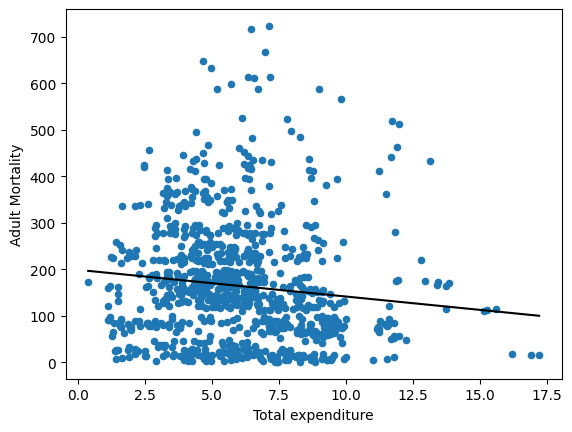

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


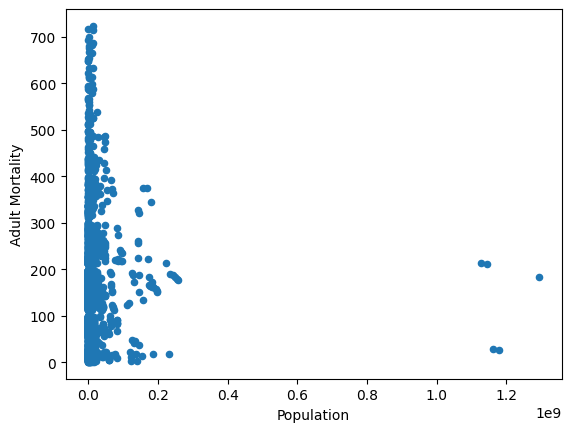

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


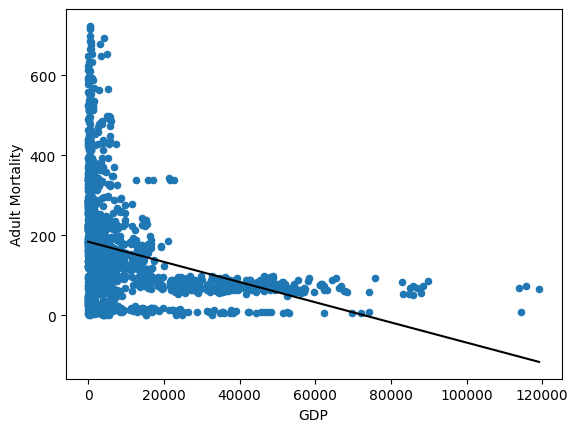

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


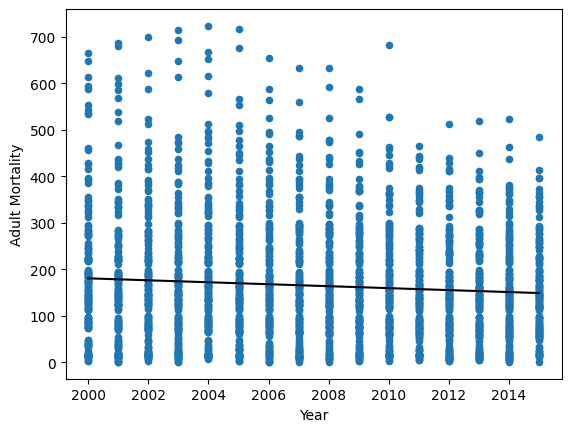

In [20]:
scatter_plot(data, "Total expenditure", "Adult Mortality", fit = True)
scatter_plot(data, "Population", "Adult Mortality", max_points = 5000, fit = False)

scatter_plot(data, "GDP", "Adult Mortality", max_points = 5000, fit = True)
scatter_plot(data, "Year", "Adult Mortality", max_points = 5000, fit = True)

In [22]:
# Use the .group_by function to countries Life Expectancy
grouped = data.group_by("Country")
bpd = grouped.count().sum("Adult Mortality").frame
bpd.show()
bpd.describe()
bpd.dim

Country                nrow    sum_Adult Mortality
-------------------  ------  ---------------------
Afghanistan              16                   4305
Albania                  16                    721
Algeria                  16                   1731
Angola                   16                   5257
Antigua and Barbuda      16                   2040
Argentina                16                   1696
Armenia                  16                   1878
Australia                16                   1011
Austria                  16                   1052
Azerbaijan               16                   1843
[193 rows x 3 columns]

Rows:193
Cols:3

Country              nrow                sum_Adult Mortality
-------  -------------------  ------------------  ---------------------
type     enum                 int                 int
mins                          1.0                 300.0
mean                          15.22279792746114   2636.743169398907
maxs                          16.0                8801.0
sigma                         3.3334007981082947  1538.9625428842928
zeros                         0                   0
missing  0                    0                   10
0        Afghanistan          16.0                4305.0
1        Albania              16.0                721.0
2        Algeria              16.0                1731.0
3        Angola               16.0                5257.0
4        Antigua and Barbuda  16.0                2040.0
5        Argentina            16.0                1696.0
6        Armenia              16.0                1878.0
7        Australia            16.0                1011.0
8        Austria              16.0                1052.0
9        Azerbaijan           16.0                1843.0
[193 rows x 3 columns]

[193, 3]

In [23]:
# Create a test/train split
train,test = data.split_frame([.9])

In [29]:
#  Set response variable and your choice of predictor variables
myY = "Life expectancy "
myX = ["Adult Mortality", "Country", "Year", "Status","Adult Mortality", "infant deaths", "Alcohol", "percentage expenditure", "Hepatitis B", "Measles ", "under-five deaths ", "Polio", "Total expenditure", "Diphtheria ", "GDP", "Population", "Income composition of resources", "Schooling"]

In [30]:
# Build simple GLM model
data_glm = H2OGeneralizedLinearEstimator(family="gaussian", standardize=True)
data_glm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708385183807_11


GLM Model: summary
    family    link      regularization                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 1.3337 )  210                           10                             1                       py_53_sid_a851

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 28.928112747576897
RMSE: 5.3784861018298535
MAE: 3.974274606883487
RMSLE: 0.08524170153506463
Mean Residual Deviance: 28.928112747576897
R^2: 0.6836004679989911
Null degrees of freedom: 2646
Residual degrees of freedom: 2636
Null deviance: 242012.7297868462
Residual deviance: 76572.71444283605
AIC: 16442.522939714952

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 28.921493444544904
RMSE: 5.377870716607541
MAE: 4.145251377213203
RMSLE: 0.08418254443531044
Mean Residual Deviance: 28.921493444544904
R^2: 0.6538469589992842
Null degrees of freedom: 280
Residual degrees of freedom: 270
Null deviance: 23478.047357460673
Residual deviance: 8126.939657917118
AIC: 1766.8918509179944

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective         training_rmse       training_deviance    training_mae       training_r2         validation_rmse    validation_deviance    validation_mae     validation_r2
--  -------------------  ----------  ------------  -------------------------  ----------------  ------------------  -------------------  -----------------  ------------------  -----------------  ---------------------  -----------------  ------------------
    2024-02-19 23:50:26  0.000 sec   0             242012.7290215339          91.0849563498434
    2024-02-19 23:50:26  0.044 sec   1                                                          5.3784861018298535  28.928112747576897   3.974274606883487  0.6836004679989911  5.377870716607541  28.921493444544904     4.145251377213203  0.6538469589992842

Variable Importances: 
variable                         relative_importance    scaled_importance     percentage
-------------------------------  ---------------------  --------------------  --------------------
Adult Mortality                  2.3528594970703125     1.0                   0.28001216692538994
Schooling                        1.6977258920669556     0.7215585521281218    0.20204517374494232
Income composition of resources  1.5507901906967163     0.6591087111779088    0.1845584584563272
Diphtheria                       0.8305078148841858     0.35297807451668967   0.09883815552257004
Polio                            0.7152144312858582     0.3039766854656705    0.08511717039204009
GDP                              0.4061560332775116     0.17262230650969215   0.048336346105437744
Alcohol                          0.3884483873844147     0.16509629574910667   0.0462289715240624
percentage expenditure           0.30088040232658386    0.1278786101342763    0.03580756672710583
under-five deaths                0.12326646596193314    0.05239006668924331   0.014669856099020707
Measles                          0.036855392158031464   0.015664085426232353  0.004386134503103741
---                              ---                    ---                   ---
Country.Yemen                    0.0                    0.0                   0.0
Country.Zambia                   0.0                    0.0                   0.0
Country.Zimbabwe                 0.0                    0.0                   0.0
Status.Developed                 0.0                    0.0                   0.0
Status.Developing                0.0                    0.0                   0.

In [31]:
# Build simple GBM model

data_gbm = H2OGradientBoostingEstimator(balance_classes=True,
                                        ntrees         =10,
                                        max_depth      =1,
                                        learn_rate     =0.1,
                                        min_rows       =2)

data_gbm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1708385183807_12


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    10                 10                          1099                   1            1            1             2             2             2

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 30.31311767007281
RMSE: 5.505734980007012
MAE: 3.9907644939818923
RMSLE: 0.08611917474424415
Mean Residual Deviance: 30.31311767007281

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 27.08142848359743
RMSE: 5.203981983404384
MAE: 3.7280331739314057
RMSLE: 0.0815483522646271
Mean Residual Deviance: 27.08142848359743

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2024-02-19 23:50:49  0.042 sec   0                  9.56185          7.83685         91.4291              9.14067            7.3686            83.5518
    2024-02-19 23:50:49  0.226 sec   1                  8.91315          7.19745         79.4442              8.50413            6.76696           72.3202
    2024-02-19 23:50:49  0.289 sec   2                  8.34539          6.65716         69.6456              7.94928            6.27072           63.1911
    2024-02-19 23:50:49  0.331 sec   3                  7.84113          6.1045          61.4833              7.45368            5.73365           55.5573
    2024-02-19 23:50:49  0.369 sec   4                  7.38599          5.71059         54.5528              6.99536            5.34104           48.9351
    2024-02-19 23:50:49  0.412 sec   5                  6.98513          5.25793         48.792               6.60597            4.9211            43.6388
    2024-02-19 23:50:49  0.460 sec   6                  6.61893          4.98342         43.8102              6.25927            4.66831           39.1784
    2024-02-19 23:50:49  0.502 sec   7                  6.29689          4.63178         39.6508              5.94725            4.34017           35.3698
    2024-02-19 23:50:50  0.546 sec   8                  6.00271          4.42399         36.0325              5.67388            4.13092           32.1929
    2024-02-19 23:50:50  0.593 sec   9                  5.74331          4.15161         32.9856              5.42611            3.88511           29.4426
    2024-02-19 23:50:50  0.636 sec   10                 5.50573          3.99076         30.3131              5.20398            3.72803           27.0814

Variable Importances: 
variable                         relative_importance    scaled_importance    percentage
-------------------------------  ---------------------  -------------------  ------------
Country                          851442                 1                    1
Year                             0                      0                    0
Status                           0                      0                    0
Adult Mortality                  0                      0                    0
infant deaths                    0                      0                    0
Alcohol                          0                      0                    0
percentage expenditure           0                      0                    0
Hepatitis B                      0                      0                    0
Measles                          0                      0                    0
under-five deaths    

In [32]:
# Variable importances from each algorithm
# Calculate magnitude of normalized GLM coefficients
from six import iteritems
glm_varimp = data_glm.coef_norm()
for k,v in iteritems(glm_varimp):
    glm_varimp[k] = abs(glm_varimp[k])

# Sort in descending order by magnitude
glm_sorted = sorted(glm_varimp.items(), key = operator.itemgetter(1), reverse = True)
table = tabulate(glm_sorted, headers = ["Predictor", "Normalized Coefficient"], tablefmt = "orgtbl")
print("Variable Importances:\n\n" + table)

data_glm.varimp()
data_gbm.varimp()

Variable Importances:

| Predictor                                                    |   Normalized Coefficient |
|--------------------------------------------------------------+--------------------------|
| Intercept                                                    |               69.2184    |
| Adult Mortality                                              |                2.35286   |
| Schooling                                                    |                1.69773   |
| Income composition of resources                              |                1.55079   |
| Diphtheria                                                   |                0.830508  |
| Polio                                                        |                0.715214  |
| GDP                                                          |                0.406156  |
| Alcohol                                                      |                0.388448  |
| percentage expenditure                                 

[('Country', 851441.5, 1.0, 1.0),
 ('Year', 0.0, 0.0, 0.0),
 ('Status', 0.0, 0.0, 0.0),
 ('Adult Mortality', 0.0, 0.0, 0.0),
 ('infant deaths', 0.0, 0.0, 0.0),
 ('Alcohol', 0.0, 0.0, 0.0),
 ('percentage expenditure', 0.0, 0.0, 0.0),
 ('Hepatitis B', 0.0, 0.0, 0.0),
 ('Measles ', 0.0, 0.0, 0.0),
 ('under-five deaths ', 0.0, 0.0, 0.0),
 ('Polio', 0.0, 0.0, 0.0),
 ('Total expenditure', 0.0, 0.0, 0.0),
 ('Diphtheria ', 0.0, 0.0, 0.0),
 ('GDP', 0.0, 0.0, 0.0),
 ('Population', 0.0, 0.0, 0.0),
 ('Income composition of resources', 0.0, 0.0, 0.0),
 ('Schooling', 0.0, 0.0, 0.0)]

In [33]:
dir(data_glm)

['HGLM',
 'Lambda',
 '_H2OEstimator__default_params',
 '_ModelBase__generate_partial_plots',
 '_ModelBase__generate_user_splits',
 '_ModelBase__grab_values',
 '_ModelBase__plot_1d_pdp',
 '_ModelBase__plot_1d_pdp_multinomial',
 '_ModelBase__plot_2d_pdp',
 '_ModelBase__pred_for_3d',
 '_ModelBase__set_axs_1d',
 '_ModelBase__set_axs_1d_multinomial',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_allowed_metrics',
 '_allowed_metrics_',
 '_bc',
 '_bci',
 '_check_and_save_parm',
 '_check_targets',
 '_default_metric',
 '_default_metrics_',
 '_default_param_value',
 '_end_time',
 '_estimator_type',
 '_extract_scoring_history',
 '_fillMultinomi

**Why we are getting Variable importance for only 1 variable whereas other variables are also important?**


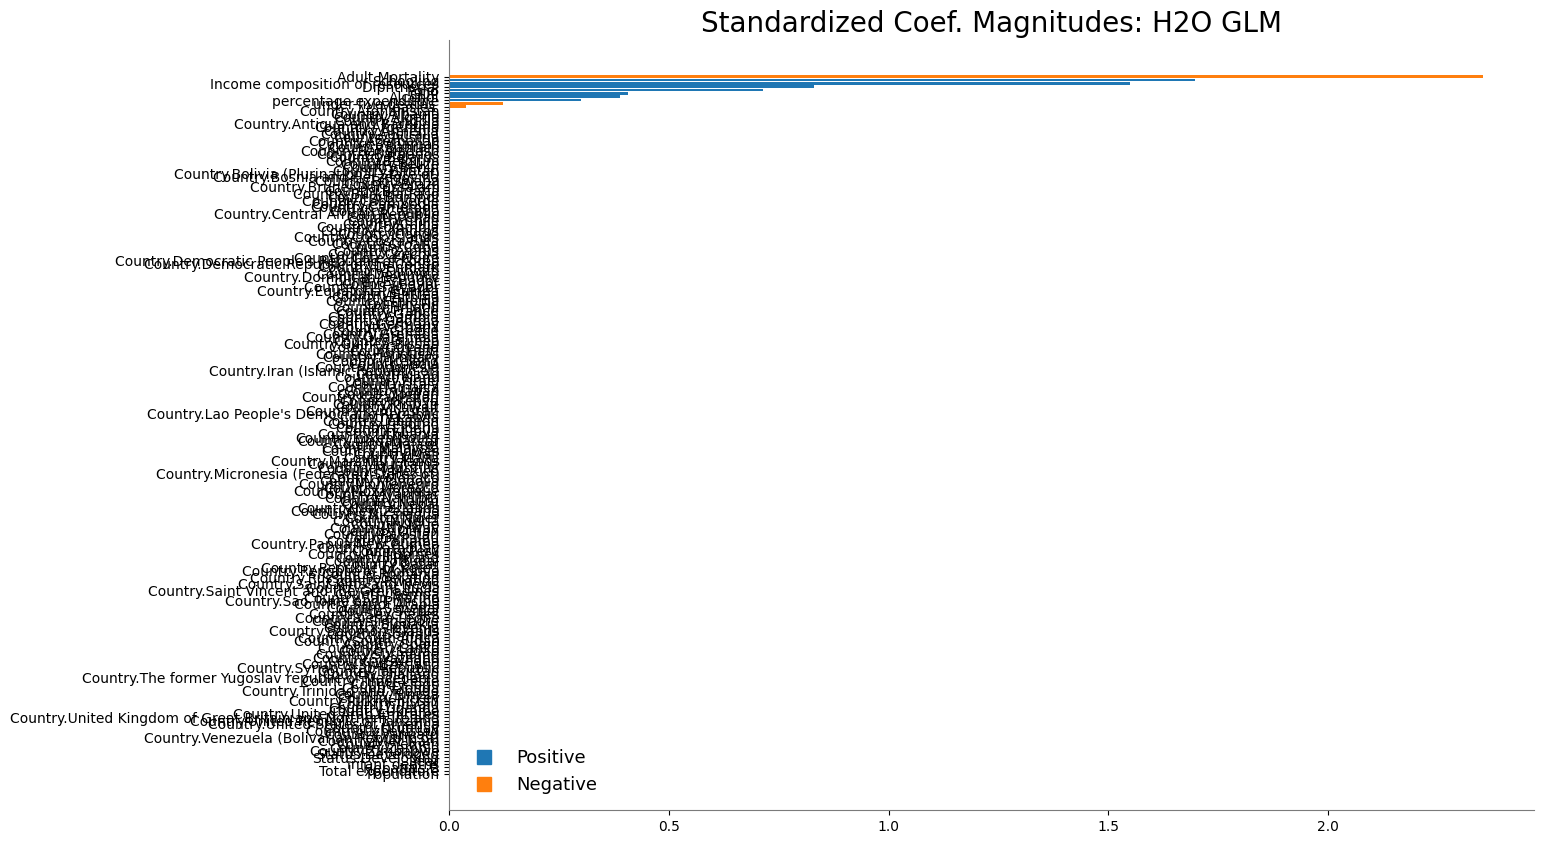

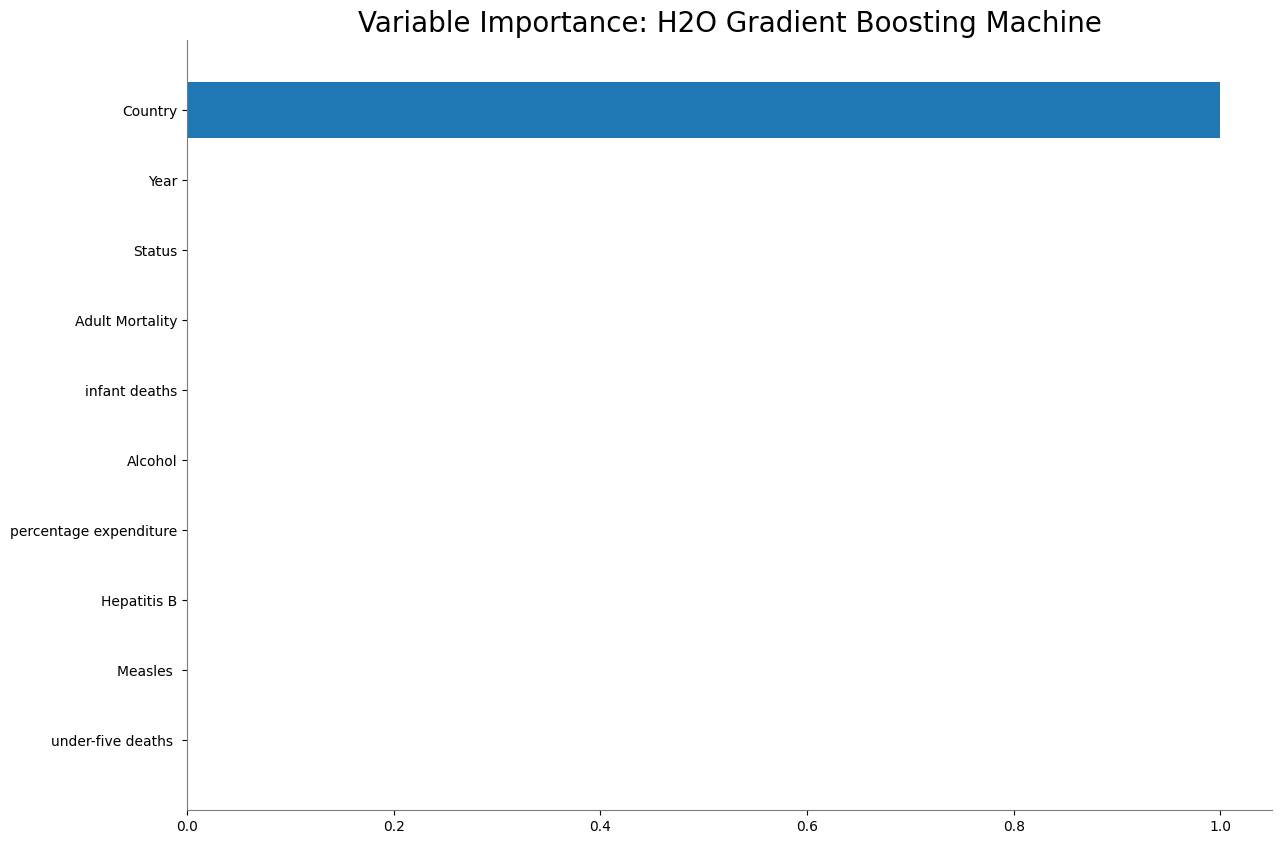

<Figure size 640x480 with 0 Axes>

In [34]:
data_glm.std_coef_plot()
data_gbm.varimp_plot()

In [35]:
# Model performance of GBM model on test data
data_gbm.model_performance(test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 27.08142848359743
RMSE: 5.203981983404384
MAE: 3.7280331739314057
RMSLE: 0.0815483522646271
Mean Residual Deviance: 27.08142848359743

Pause.. it is important to check that output and understand it. Key is know your data best to validate the results
What you think was not normal in above plots ?? Adult Mortality as standard deviation as 1 ?? How is that possible ?

Adult Mortality cannot be used because its like having measure for other country to measure other country. Lets now remove the Adult Mortality and see difference !!

**We dropped Adult Mortality**

In [45]:
data=data[[ "Country", "Year", "Status","infant deaths", "Alcohol", "percentage expenditure", "Hepatitis B", "Measles ", "under-five deaths ", "Polio", "Total expenditure", "Diphtheria ", "GDP", "Population", "Income composition of resources", "Schooling"]]

In [37]:
# Create a test/train split
#https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/splitting-datasets.html check h2o split frame syntax here
train,test = data.split_frame([.9])

In [46]:
#  Set response variable and your choice of predictor variables
#myY target
#myX features

#  Set response variable and your choice of predictor variables
myY = "Adult Mortality"
myX = [ "Country", "Year", "Status", "infant deaths", "Alcohol", "percentage expenditure", "Hepatitis B", "Measles ", "under-five deaths ", "Polio", "Total expenditure", "Diphtheria ", "GDP", "Population", "Income composition of resources", "Schooling"]

# GLM
Generalized Linear Models (GLM) estimate regression models for outcomes following exponential distributions. In addition to the Gaussian (i.e. normal) distribution, these include Poisson, binomial, and gamma distributions. Each serves a different purpose, and depending on distribution and link function choice, can be used either for prediction or classification.

Syntax Specifics
family: Specify the model type.

If the family is gaussian, the response must be numeric (Real or Int).

If the family is binomial, the response must be categorical 2 levels/classes or binary (Enum or Int).

If the family is fractionalbinomial, the response must be a numeric between 0 and 1.

If the family is multinomial, the response can be categorical with more than two levels/classes (Enum).

If the family is ordinal, the response must be categorical with at least 3 levels.

If the family is quasibinomial, the response must be numeric.

If the family is poisson, the response must be numeric and non-negative (Int).

If the family is negativebinomial, the response must be numeric and non-negative (Int).

If the family is gamma, the response must be numeric and continuous and positive (Real or Int).

If the family is tweedie, the response must be numeric and continuous (Real) and non-negative.

If the family is AUTO (default)

We can see we have metrics for Train and validation data.

Standardization is highly recommended; if you do not use standardization, the results can include components that are dominated by variables that appear to have larger variances relative to other attributes as a matter of scale, rather than true contribution. This option is enabled by default.

**Observations :**
1.Metrics MSE for test is somewhat greator than train which is fine. 2.Scoring History The scoring_history property in H2O AutoML provides a record of the model's performance on the training and validation data during the training process.

For the provided code, the scoring_history property will contain a list of dictionaries where each dictionary corresponds to a scoring event during the model training process. Each dictionary in the list will contain various performance metrics such as the root mean squared error (RMSE), mean absolute error (MAE), and R-squared for both the training and validation sets.

This information can be used to monitor the model's performance over time and to identify any potential issues such as overfitting. The scoring history can also be visualized to gain insights into the behavior of the model during the training process.

What is scaled_importance and realtive_importance ? In H2O AutoML, the relative_importance and scaled_importance are properties of the trained models that provide information about the importance of each input feature (also known as predictor or independent variable) in predicting the target variable (also known as response or dependent variable).

The relative_importance is a measure of the feature importance relative to the most important feature in the model. The most important feature is assigned a relative importance value of 1, and the importance of other features is expressed as a ratio of their importance to the most important feature. The relative_importance property is often used to rank the features by their importance in the model.

The scaled_importance is a normalized measure of feature importance that takes into account the scale of the feature values. Features with larger values and variances tend to have higher importance values, so the scaled_importance property is calculated by dividing the relative_importance by the standard deviation of the feature values. The scaled_importance property is often used when the scale of the feature values is significantly different across the features.

Both relative_importance and scaled_importance are useful in feature selection and feature engineering tasks, as they can provide insights into which features are most important for the model and which features can be potentially dropped without significantly affecting the model's performance.**

In [47]:
# Build simple GLM model
data_glm = H2OGeneralizedLinearEstimator(family="gaussian", standardize=True)
data_glm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708385183807_13


GLM Model: summary
    family    link      regularization                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 10.644 )  209                           14                             2                       py_57_sid_a851

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 13644.16867113639
RMSE: 116.80825600588508
MAE: 86.86779478012409
RMSLE: 1.0677200488224796
Mean Residual Deviance: 13644.16867113639
R^2: 0.11700355576267629
Null degrees of freedom: 2623
Residual degrees of freedom: 2609
Null deviance: 40546367.798780486
Residual deviance: 35802298.59306189
AIC: 32461.870557361624

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 13298.418496572118
RMSE: 115.31876905591785
MAE: 87.55168266862002
RMSLE: 1.0767396991895315
Mean Residual Deviance: 13298.418496572118
R^2: 0.13265361278015408
Null degrees of freedom: 303
Residual degrees of freedom: 289
Null deviance: 4672661.523312016
Residual deviance: 4042719.222957924
AIC: 3781.316348909065

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective         training_rmse       training_deviance    training_mae       training_r2          validation_rmse     validation_deviance    validation_mae     validation_r2
--  -------------------  ----------  ------------  -------------------------  ----------------  ------------------  -------------------  -----------------  -------------------  ------------------  ---------------------  -----------------  -------------------
    2024-02-20 00:11:05  0.000 sec   0             40546367.798780486         15393.4577823768
    2024-02-20 00:11:05  0.056 sec   2                                                          116.80825600588508  13644.16867113639    86.86779478012409  0.11700355576267629  115.31876905591785  13298.418496572118     87.55168266862002  0.13265361278015408

Variable Importances: 
variable                                    relative_importance    scaled_importance    percentage
------------------------------------------  ---------------------  -------------------  --------------------
Income composition of resources             6.087318420410156      1.0                  0.21232401216362834
Schooling                                   5.7297139167785645     0.9412541814089139   0.19985086426253226
Polio                                       3.1249029636383057     0.5133463945570558   0.10899576612208707
Diphtheria                                  2.9866347312927246     0.4906322497076617   0.1041730077547979
GDP                                         2.8760135173797607     0.4724598450011719   0.10031456987685478
percentage expenditure                      2.540348529815674      0.41731816119527193  0.08860666633372793
Alcohol                                     1.3138693571090698     0.21583713326114176  0.045827406107901335
Status.Developing                           0.9882354140281677     0.16234330879007666  0.03446938267022791
Status.Developed                            0.9882352352142334     0.1623432794152482   0.034469376433246476
Hepatitis B                                 0.9033134579658508     0.14839267401178377  0.03150732792187131
---                                         ---                    ---                  ---
Country.Uruguay                             0.0                    0.0                  0.0
Country.Uzbekistan                          0.0                    0.0                  0.0
Country.Vanuatu                             0.0                    0.0                  

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

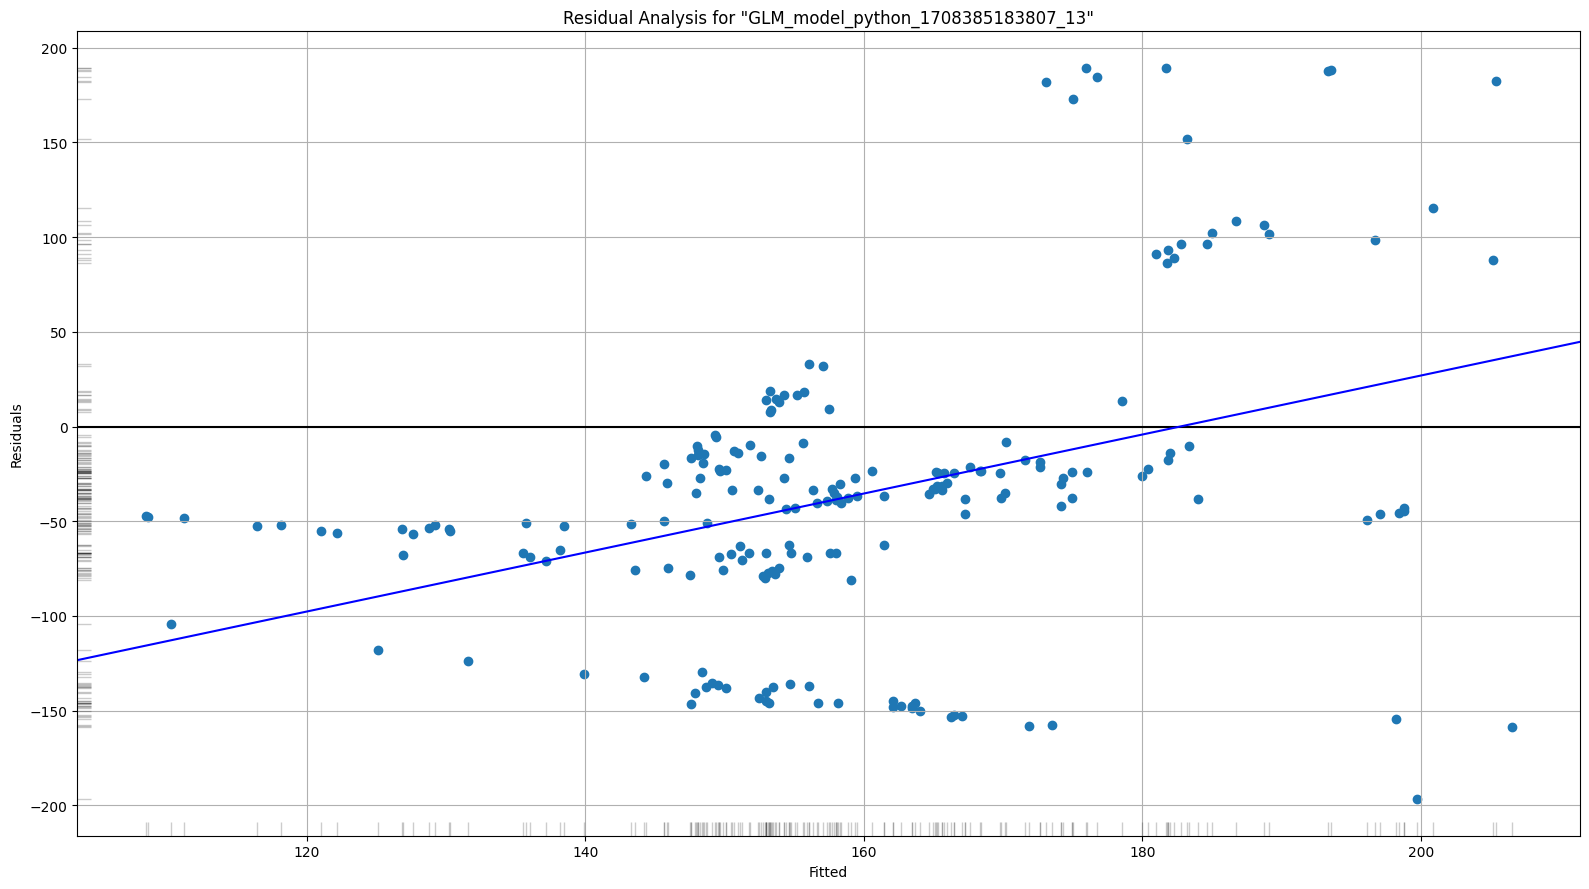

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

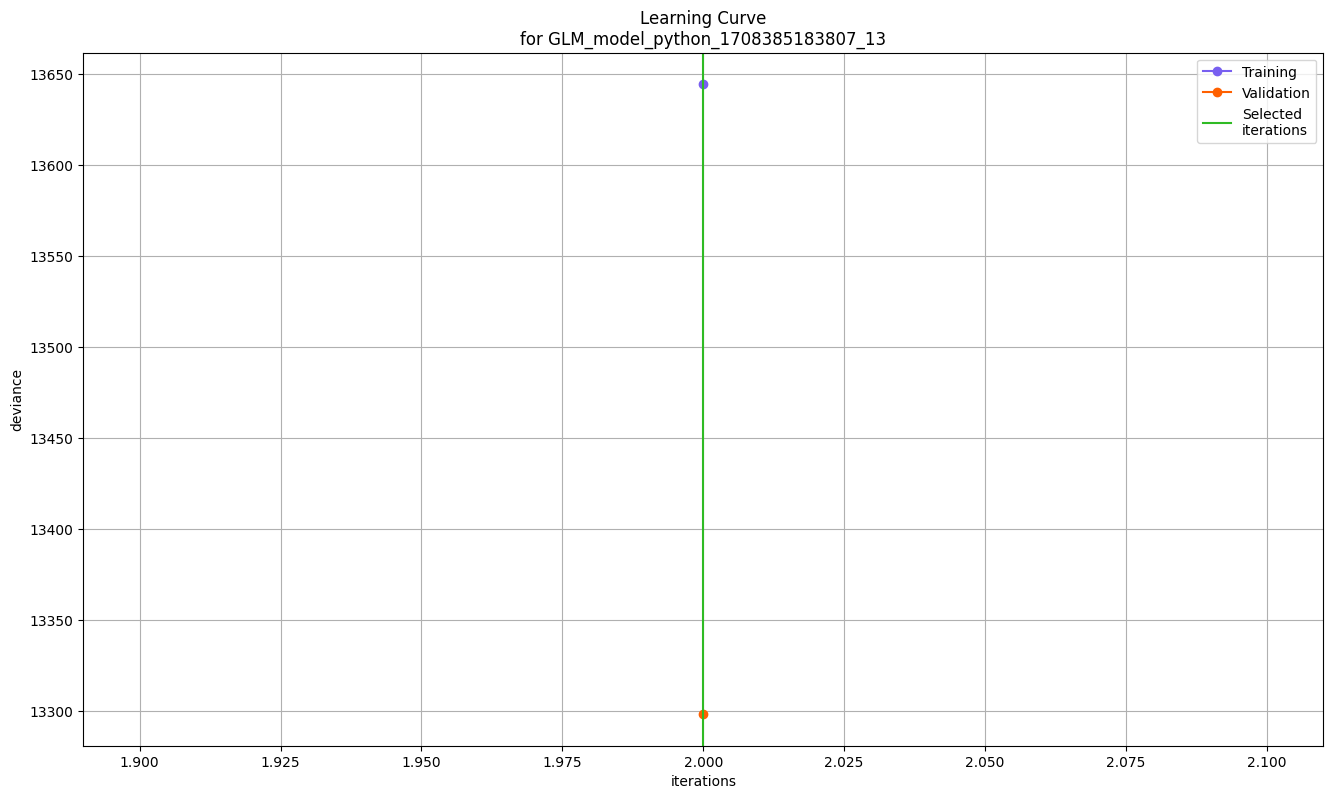

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

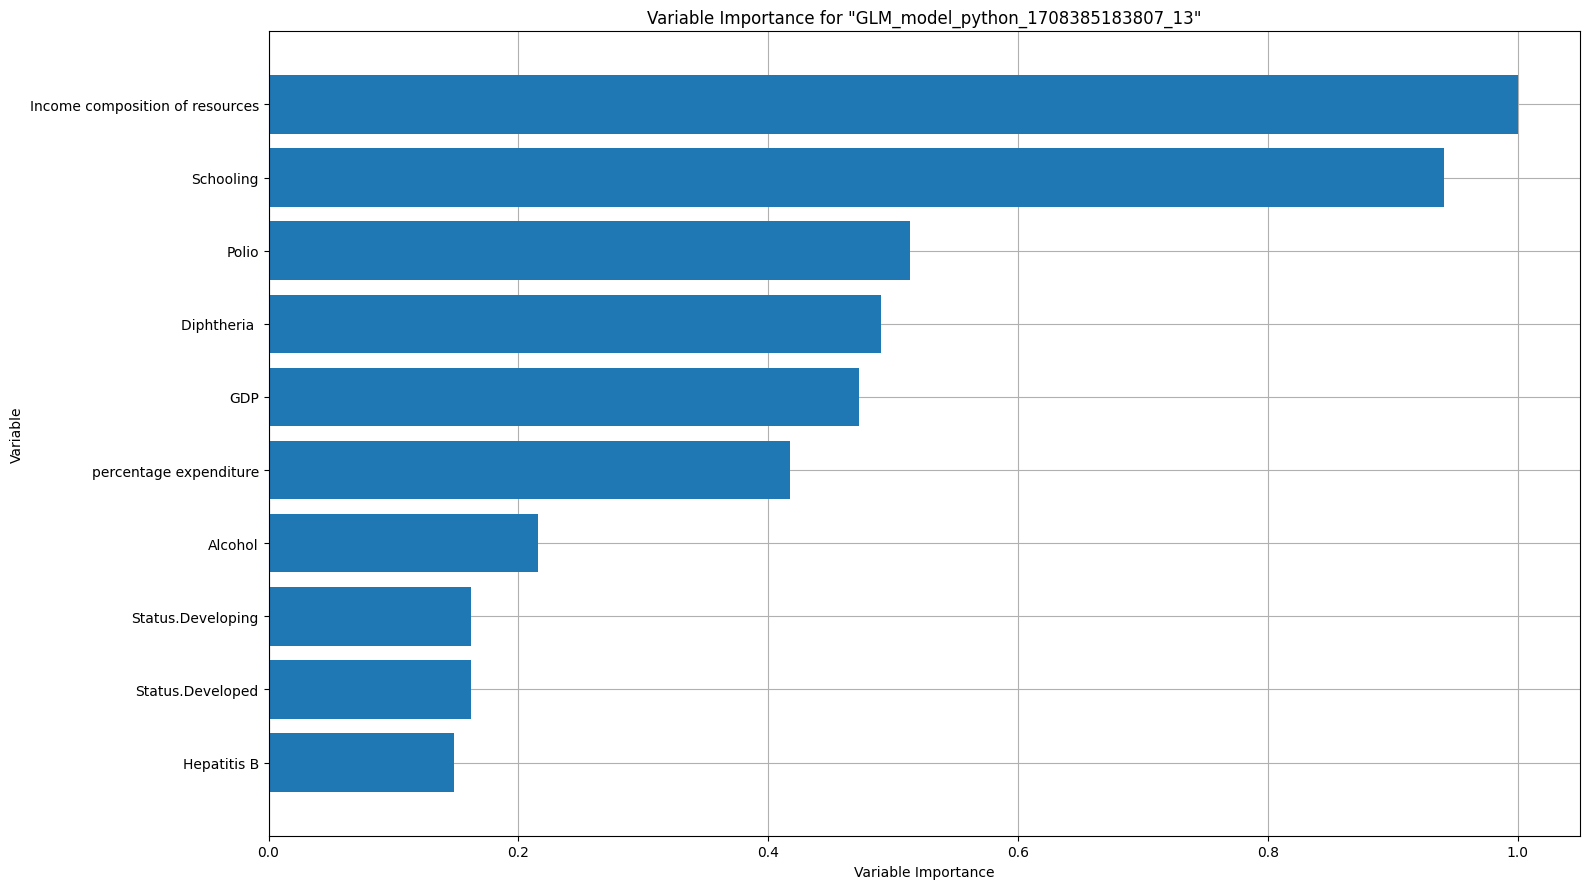

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

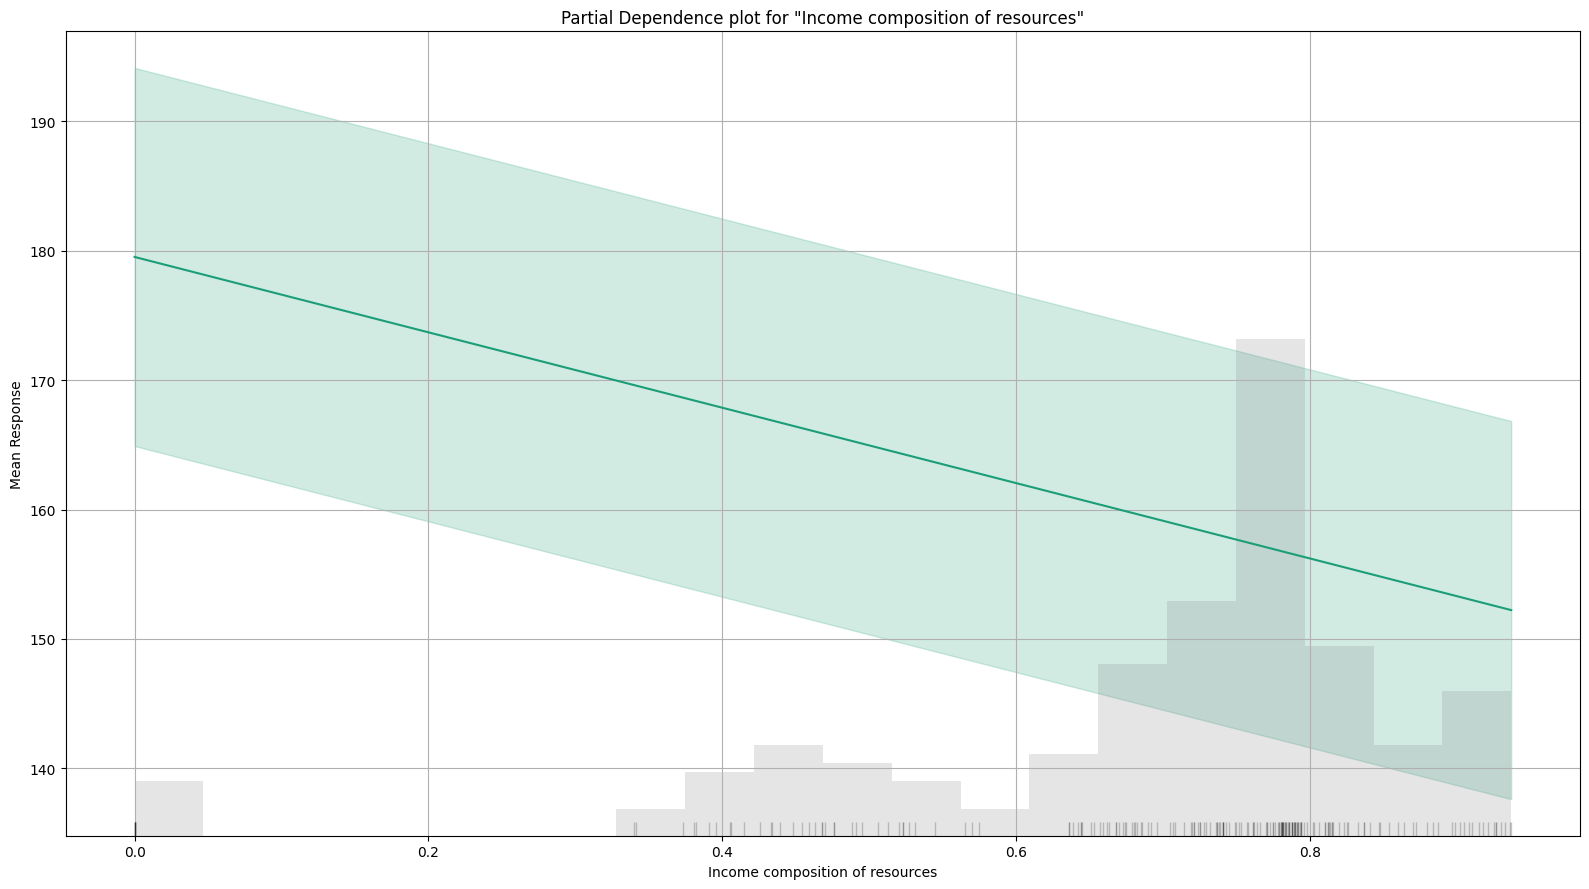

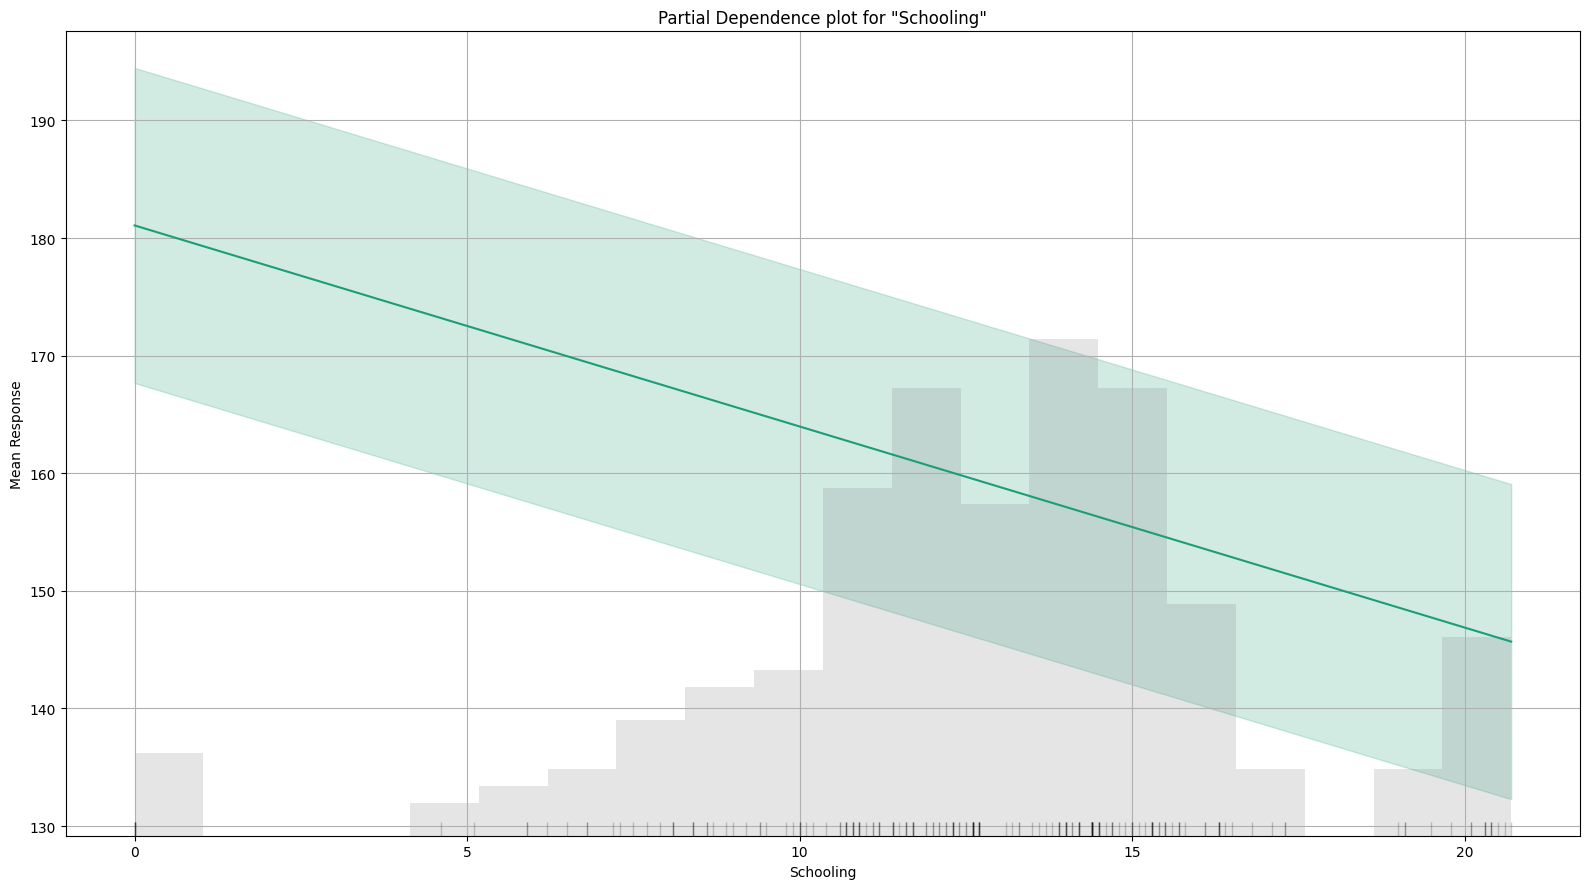

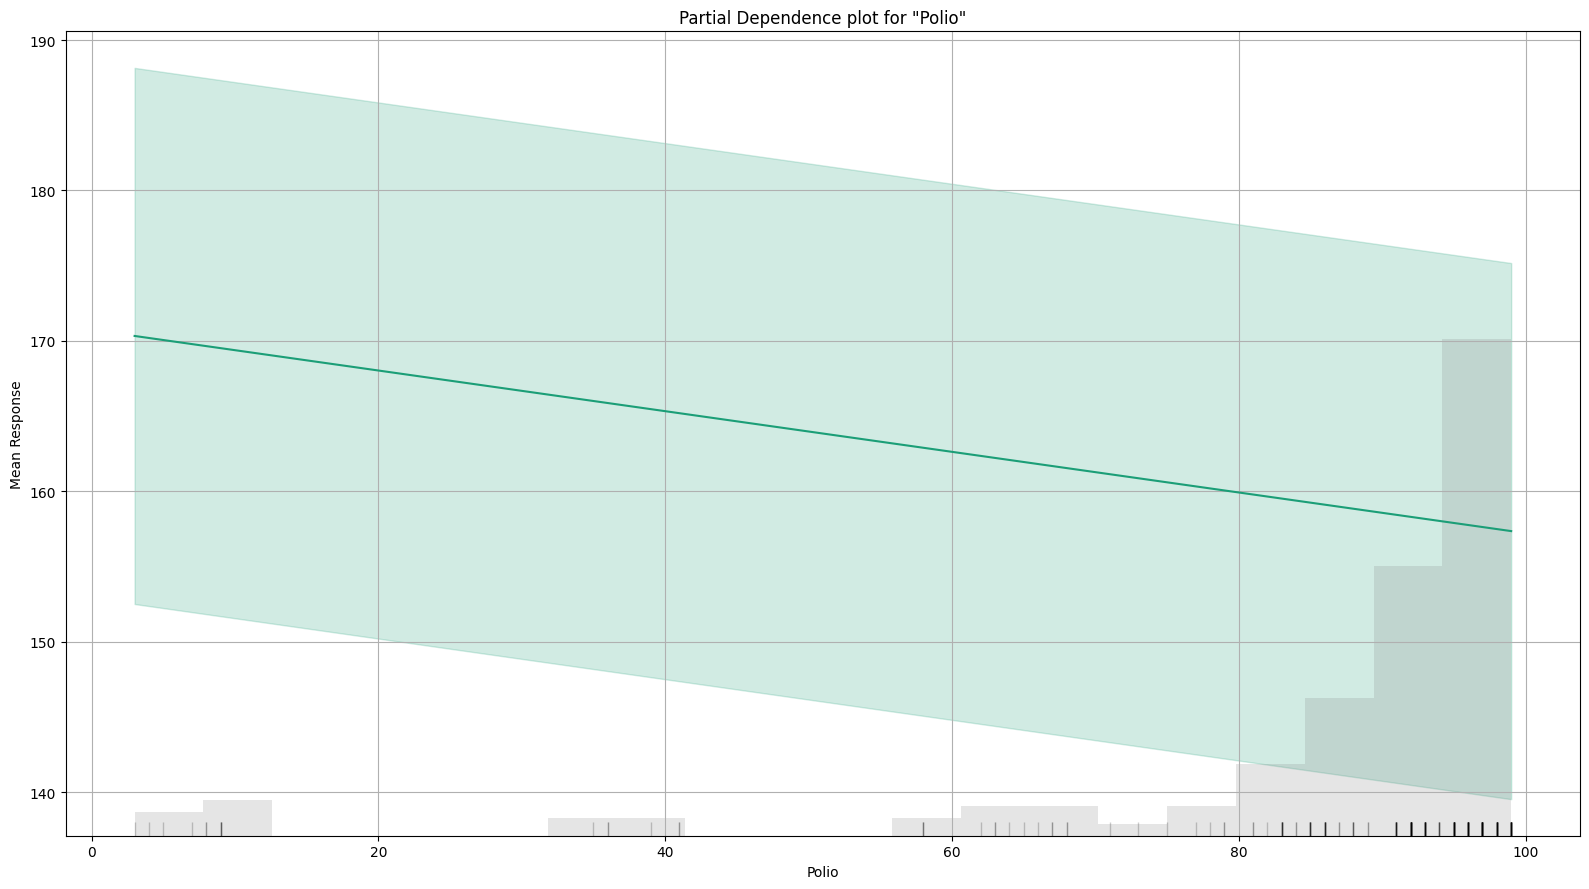

H2OServerError: HTTP 500 Server Error:
Server error java.lang.NullPointerException:
  Error: Caught exception: java.lang.NullPointerException
  Request: None
  Stacktrace: java.lang.NullPointerException
      hex.PartialDependence.checkSanityAndFillParams(PartialDependence.java:181)
      hex.PartialDependence.execImpl(PartialDependence.java:58)
      water.api.ModelsHandler.makePartialDependence(ModelsHandler.java:174)
      java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
      java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
      java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
      java.base/java.lang.reflect.Method.invoke(Method.java:566)
      water.api.Handler.handle(Handler.java:60)
      water.api.RequestServer.serve(RequestServer.java:472)


<Figure size 1600x900 with 0 Axes>

In [49]:
data_glm.explain(train[1:200,:])

# GBM Model
Gradient Boosting Machine (for Regression and Classification) is a forward learning ensemble method. The guiding heuristic is that good predictive results can be obtained through increasingly refined approximations. H2O’s GBM sequentially builds regression trees on all the features of the dataset in a fully distributed way - each tree is built in parallel.

In [50]:
# Build simple GBM model

data_gbm = H2OGradientBoostingEstimator(balance_classes=True,
                                        ntrees         =10,
                                        max_depth      =1,
                                        learn_rate     =0.1,
                                        min_rows       =2)

data_gbm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1708385183807_14


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    10                 10                          1100                   1            1            1             2             2             2

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 9287.189690767938
RMSE: 96.37006636278683
MAE: 69.05724542896922
RMSLE: 0.9919974103928015
Mean Residual Deviance: 9287.189690767938

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 8530.752576032928
RMSE: 92.36207325538405
MAE: 66.99521576868554
RMSLE: 0.9846383274015935
Mean Residual Deviance: 8530.752576032928

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2024-02-20 00:21:17  0.004 sec   0                  124.307          95.1894         15452.1              123.978            95.8401           15370.6
    2024-02-20 00:21:17  0.067 sec   1                  119.526          91.156          14286.4              118.627            91.4374           14072.4
    2024-02-20 00:21:17  0.104 sec   2                  115.476          87.4952         13334.7              113.947            87.3148           12983.9
    2024-02-20 00:21:17  0.136 sec   3                  111.937          84.8947         12529.9              110.213            84.6888           12146.9
    2024-02-20 00:21:17  0.177 sec   4                  108.929          81.5546         11865.4              106.854            81.1292           11417.8
    2024-02-20 00:21:17  0.214 sec   5                  106.196          79.7295         11277.5              103.692            78.9831           10752
    2024-02-20 00:21:17  0.258 sec   6                  103.807          76.4582         10775.9              101.008            75.596            10202.6
    2024-02-20 00:21:17  0.292 sec   7                  101.615          75.2071         10325.5              98.4665            74.0514           9695.66
    2024-02-20 00:21:17  0.335 sec   8                  99.6724          72.3836         9934.59              96.265             70.9784           9266.96
    2024-02-20 00:21:17  0.371 sec   9                  97.9267          71.4345         9589.65              94.1643            69.5641           8866.91
    2024-02-20 00:21:17  0.398 sec   10                 96.3701          69.0572         9287.19              92.3621            66.9952           8530.75

Variable Importances: 
variable                         relative_importance    scaled_importance    percentage
-------------------------------  ---------------------  -------------------  ------------
Country                          8.5141e+07             1                    1
Year                             0                      0                    0
Status                           0                      0                    0
infant deaths                    0                      0                    0
Alcohol                          0                      0                    0
percentage expenditure           0                      0                    0
Hepatitis B                      0                      0                    0
Measles                          0                      0                    0
under-five deaths                0                      0                    0
Polio                     

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

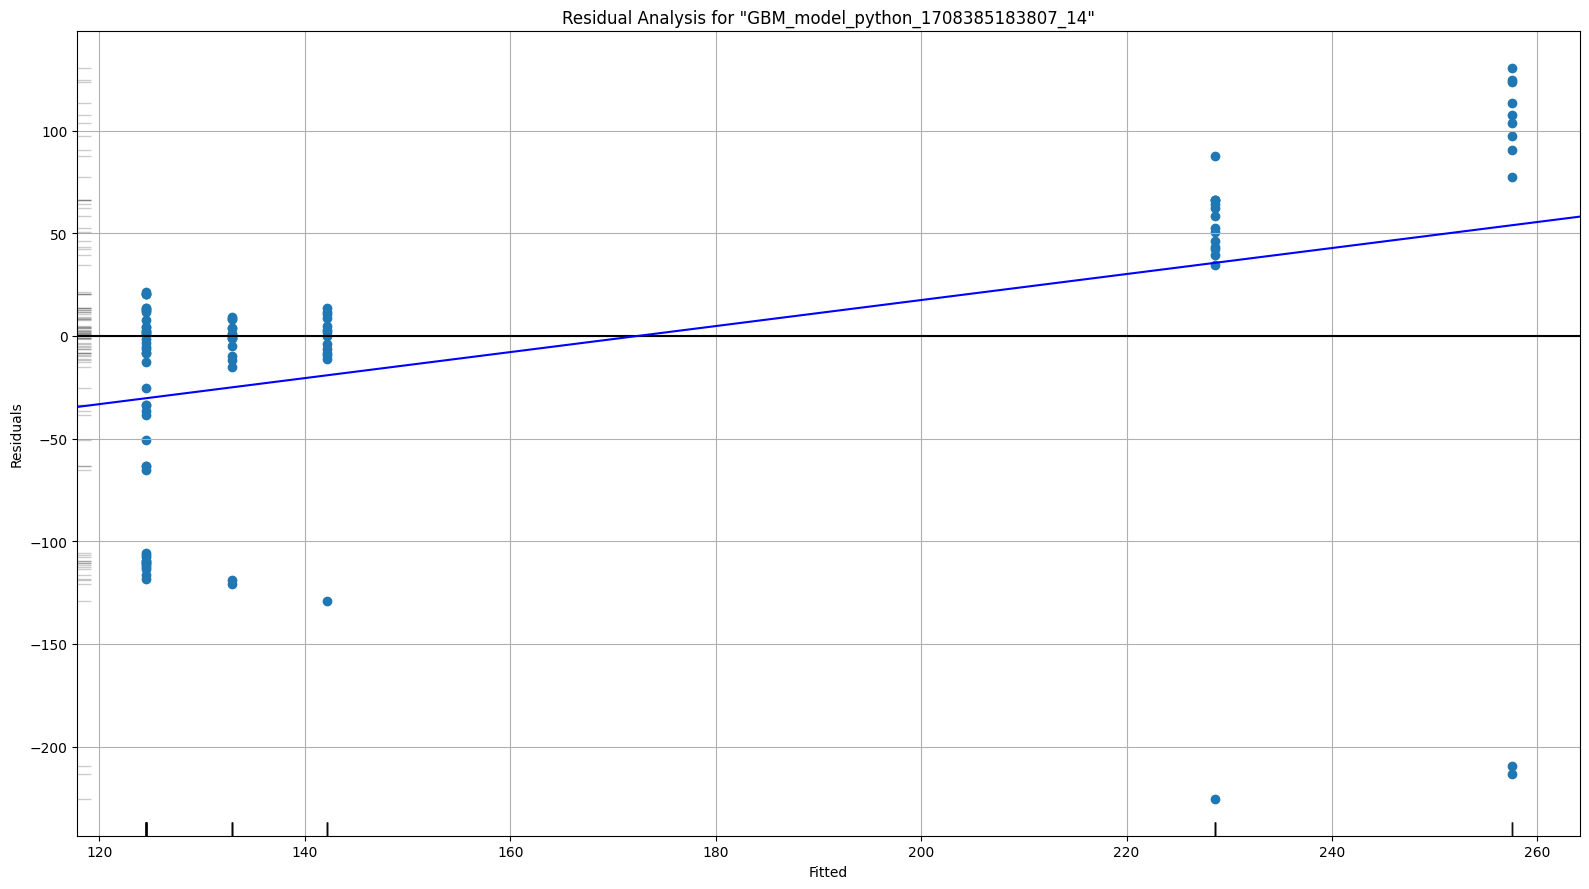

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

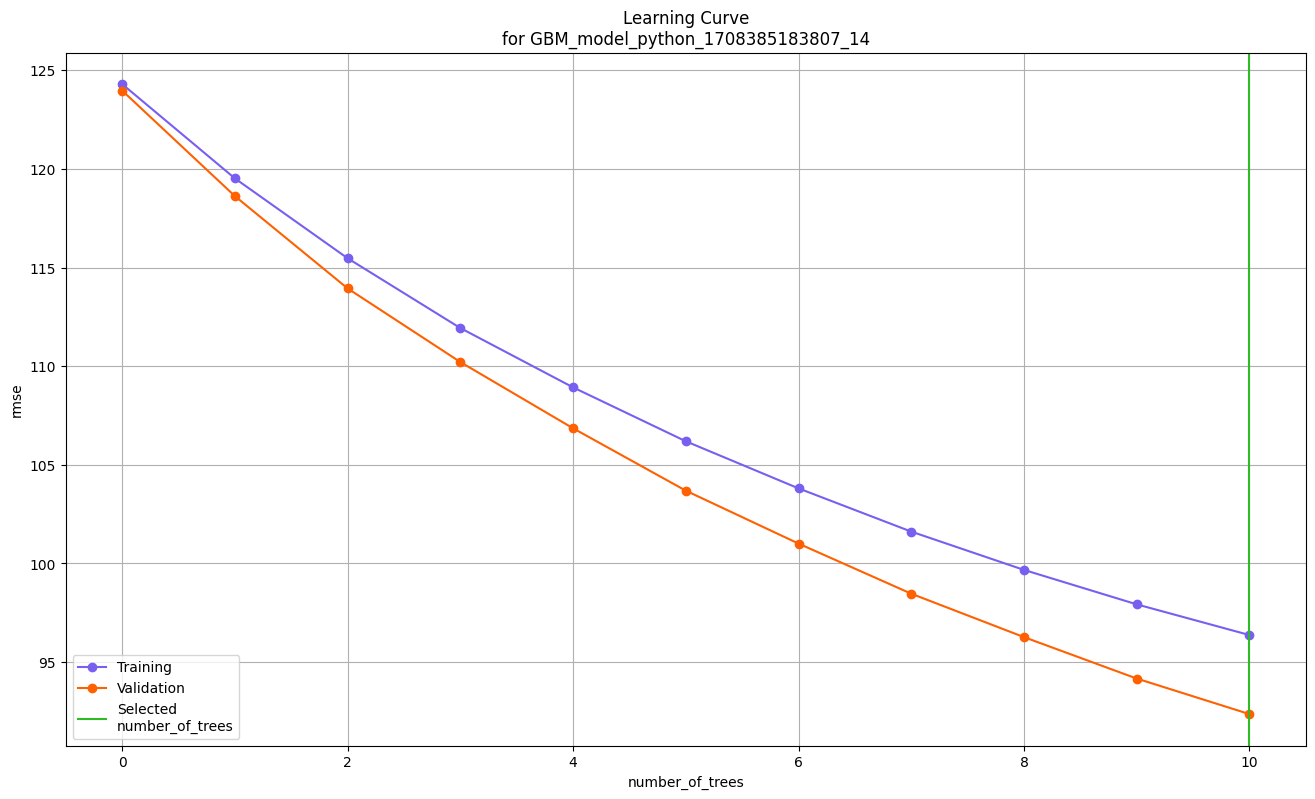

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

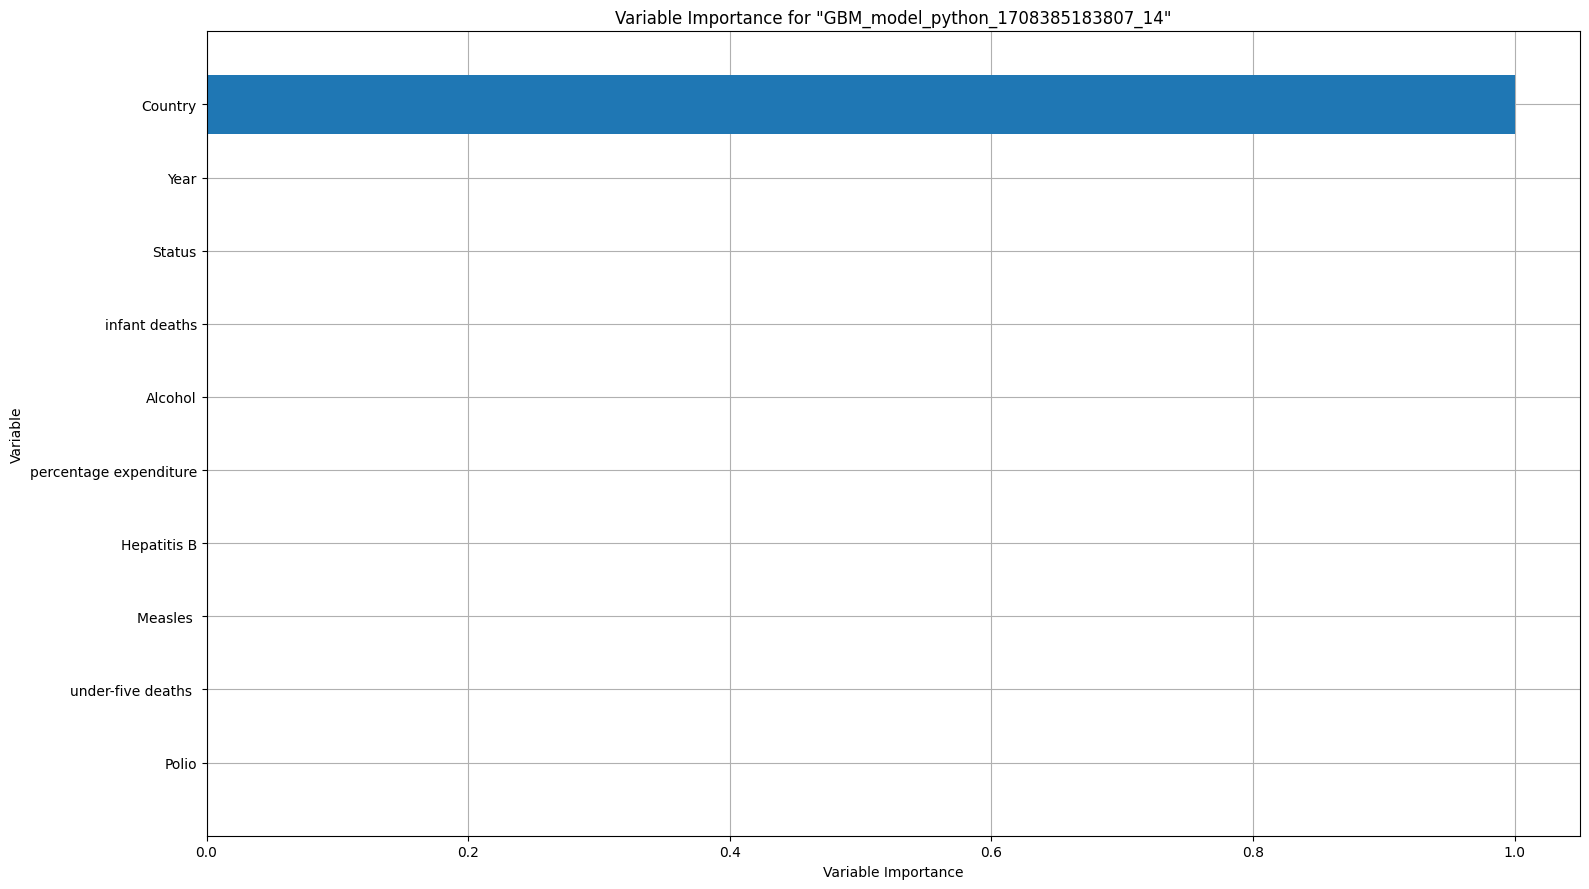

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

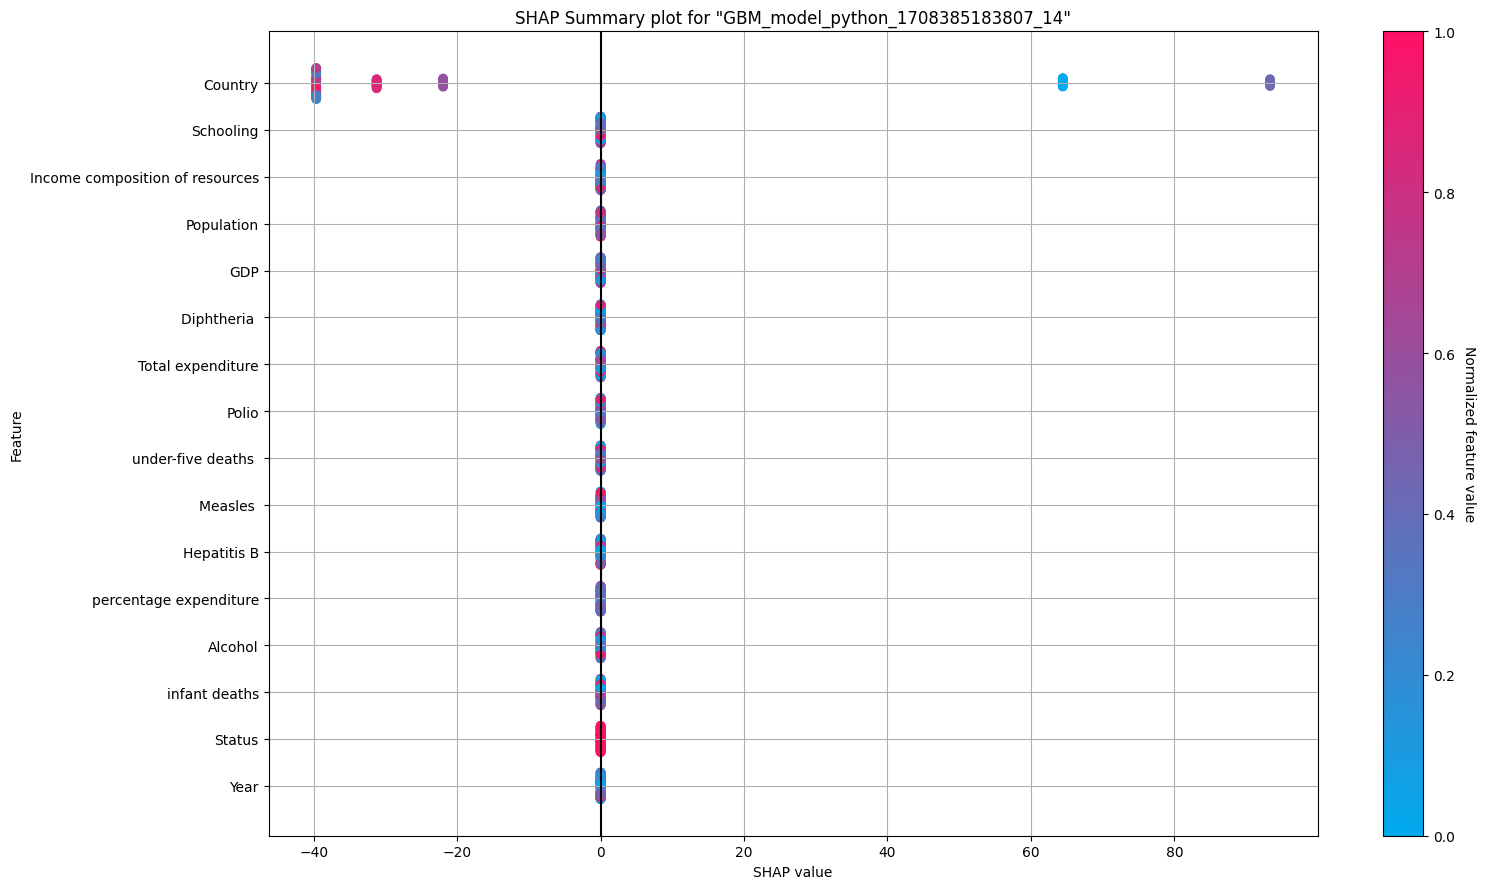

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

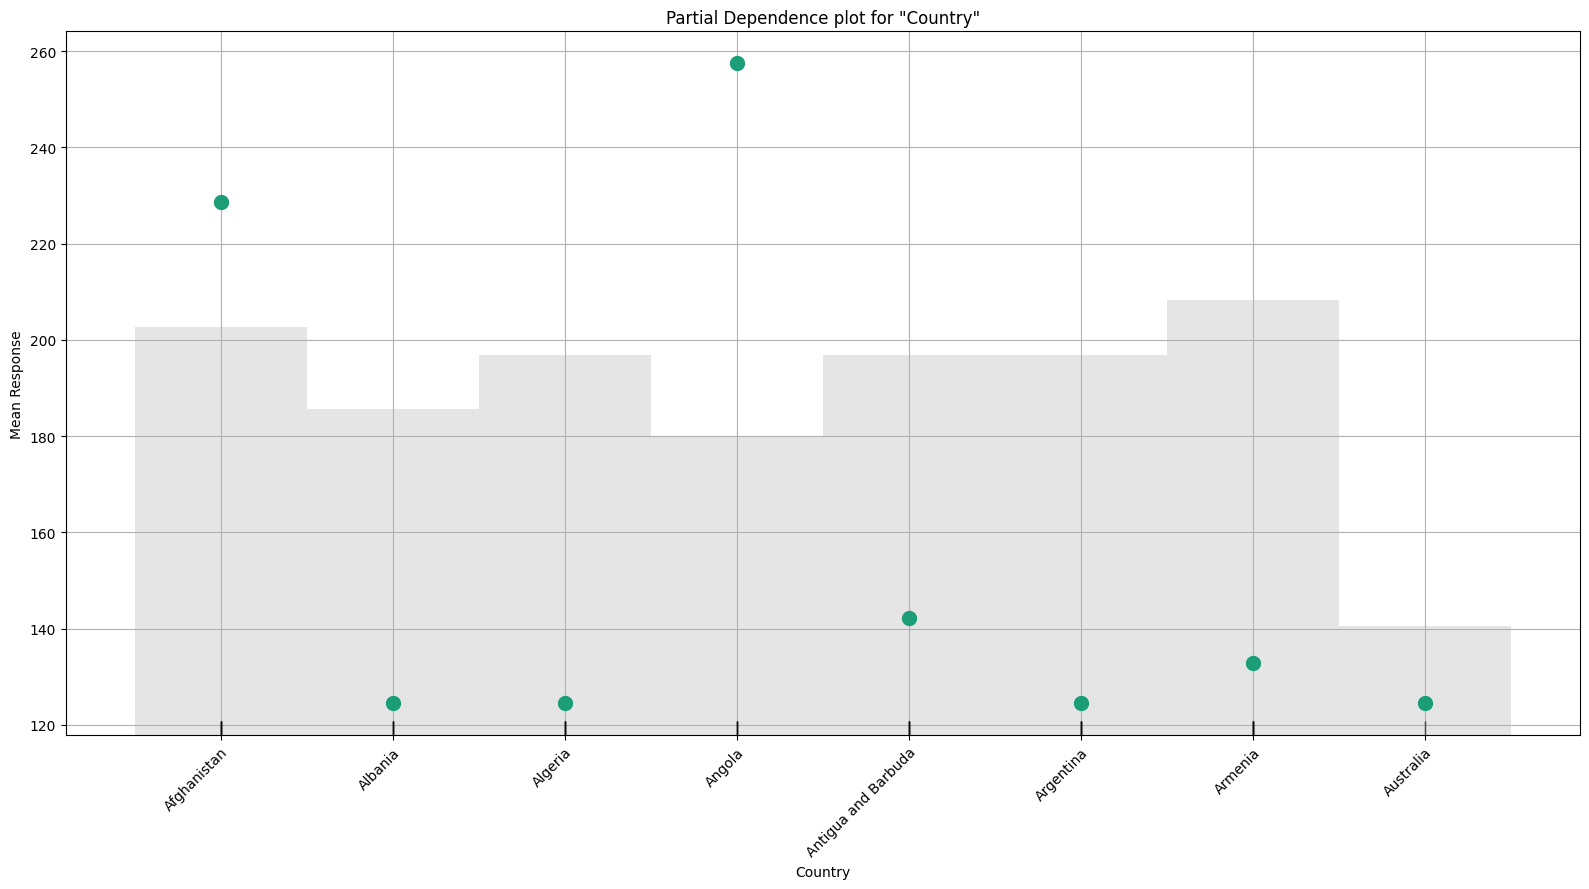

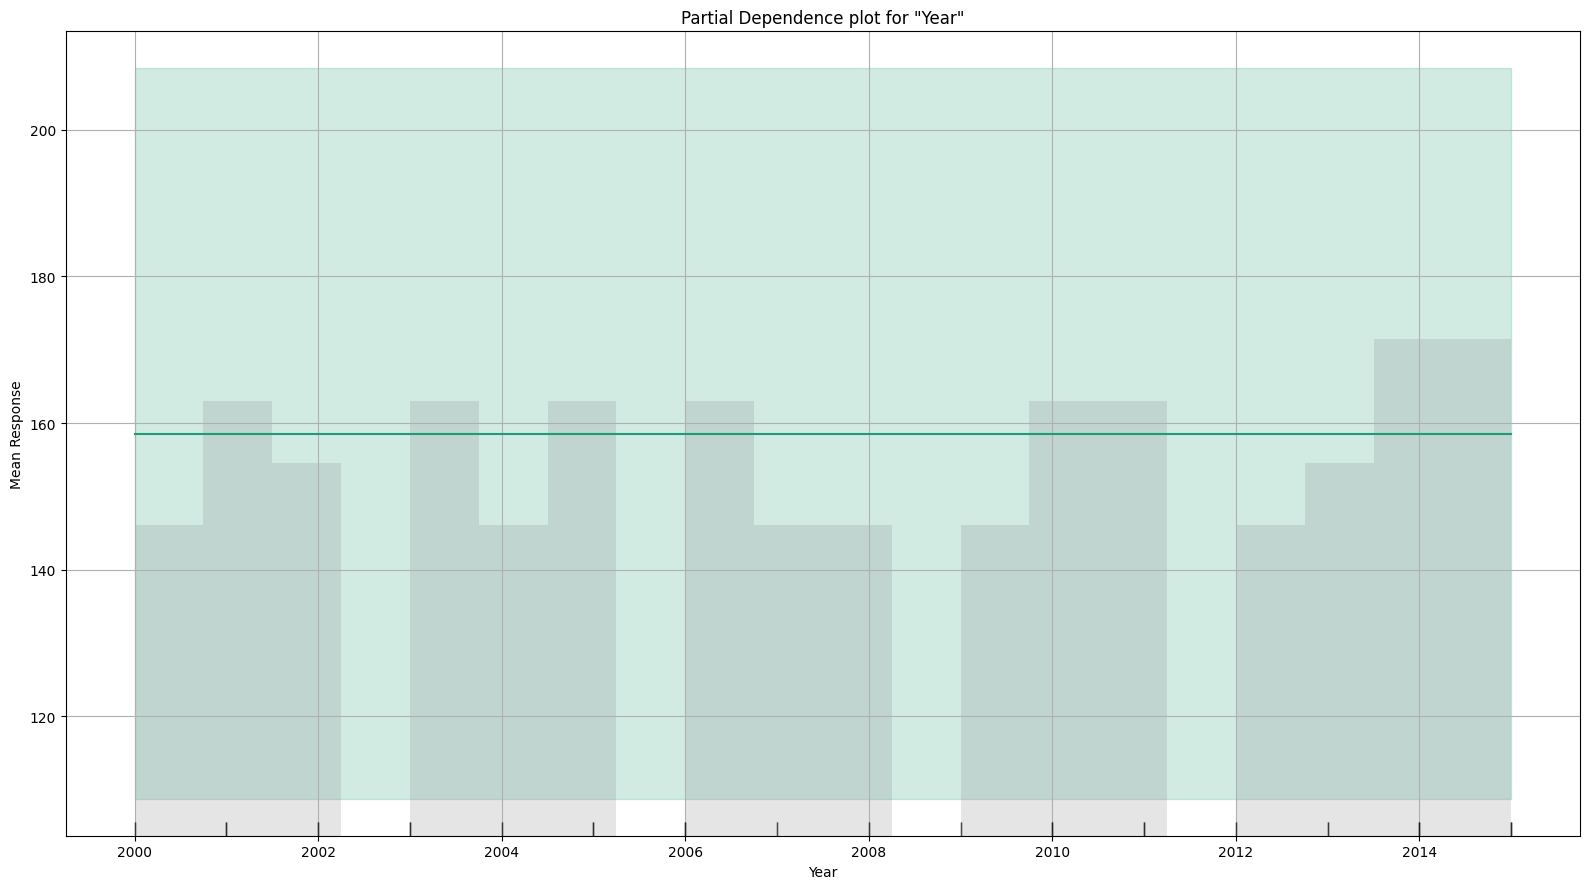

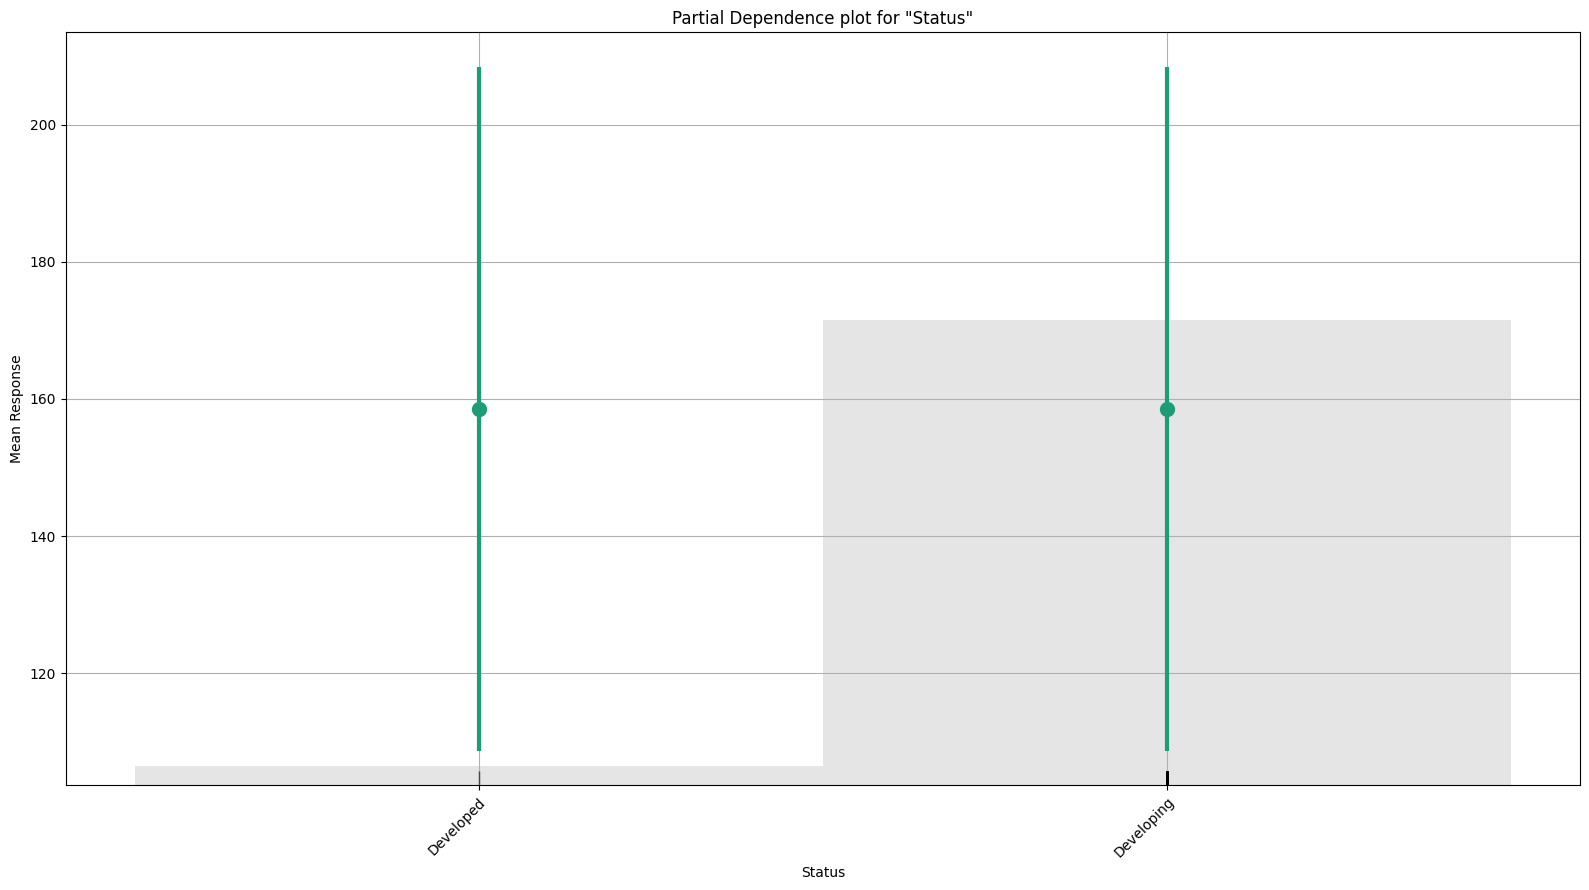

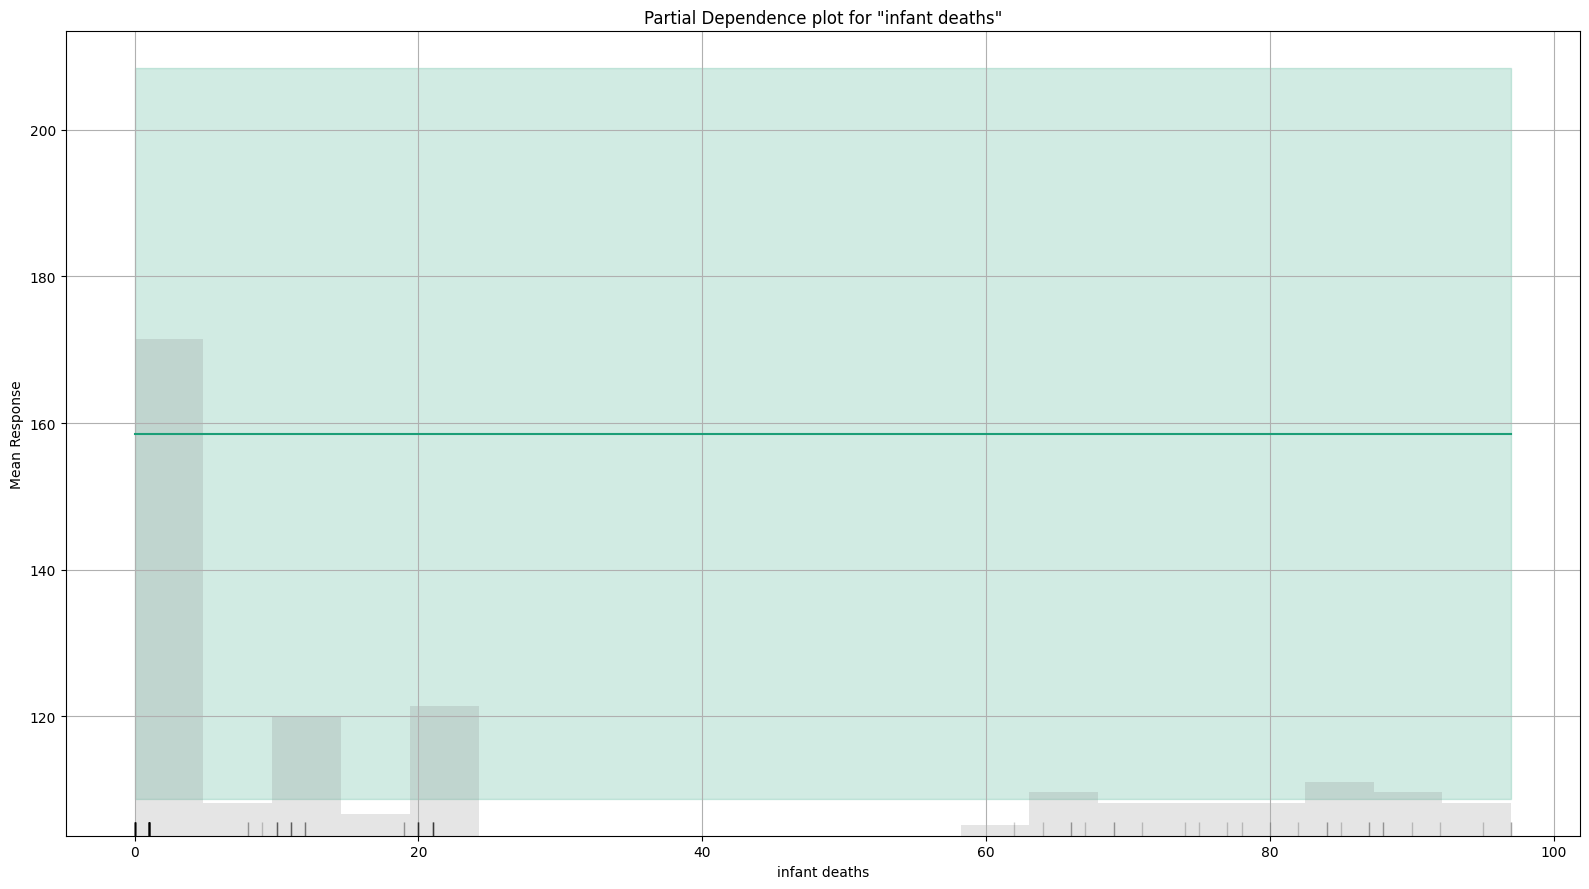

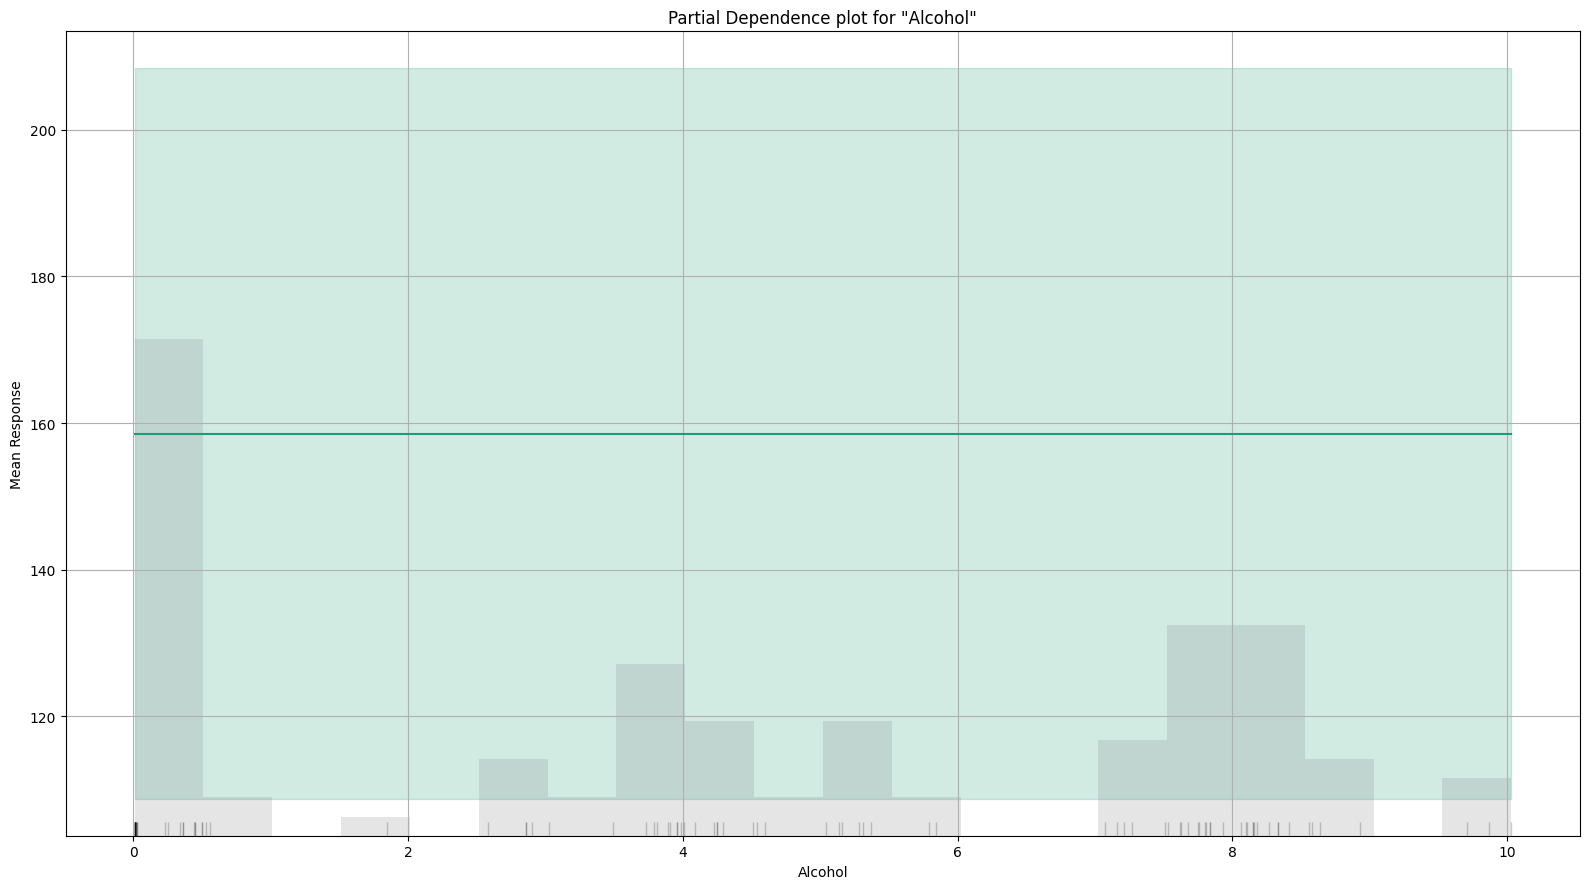

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

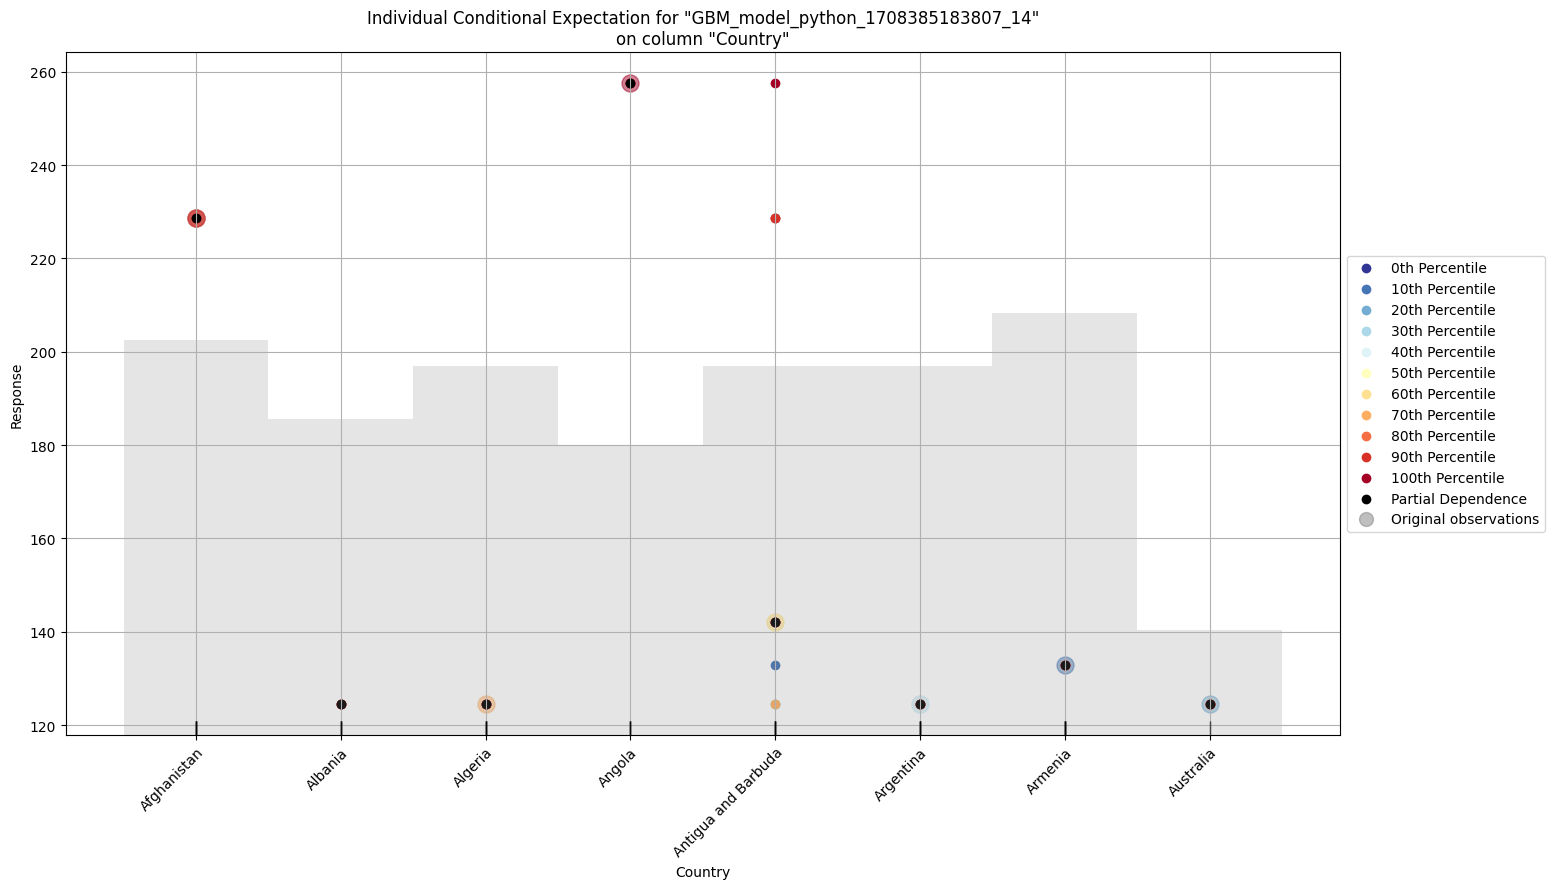

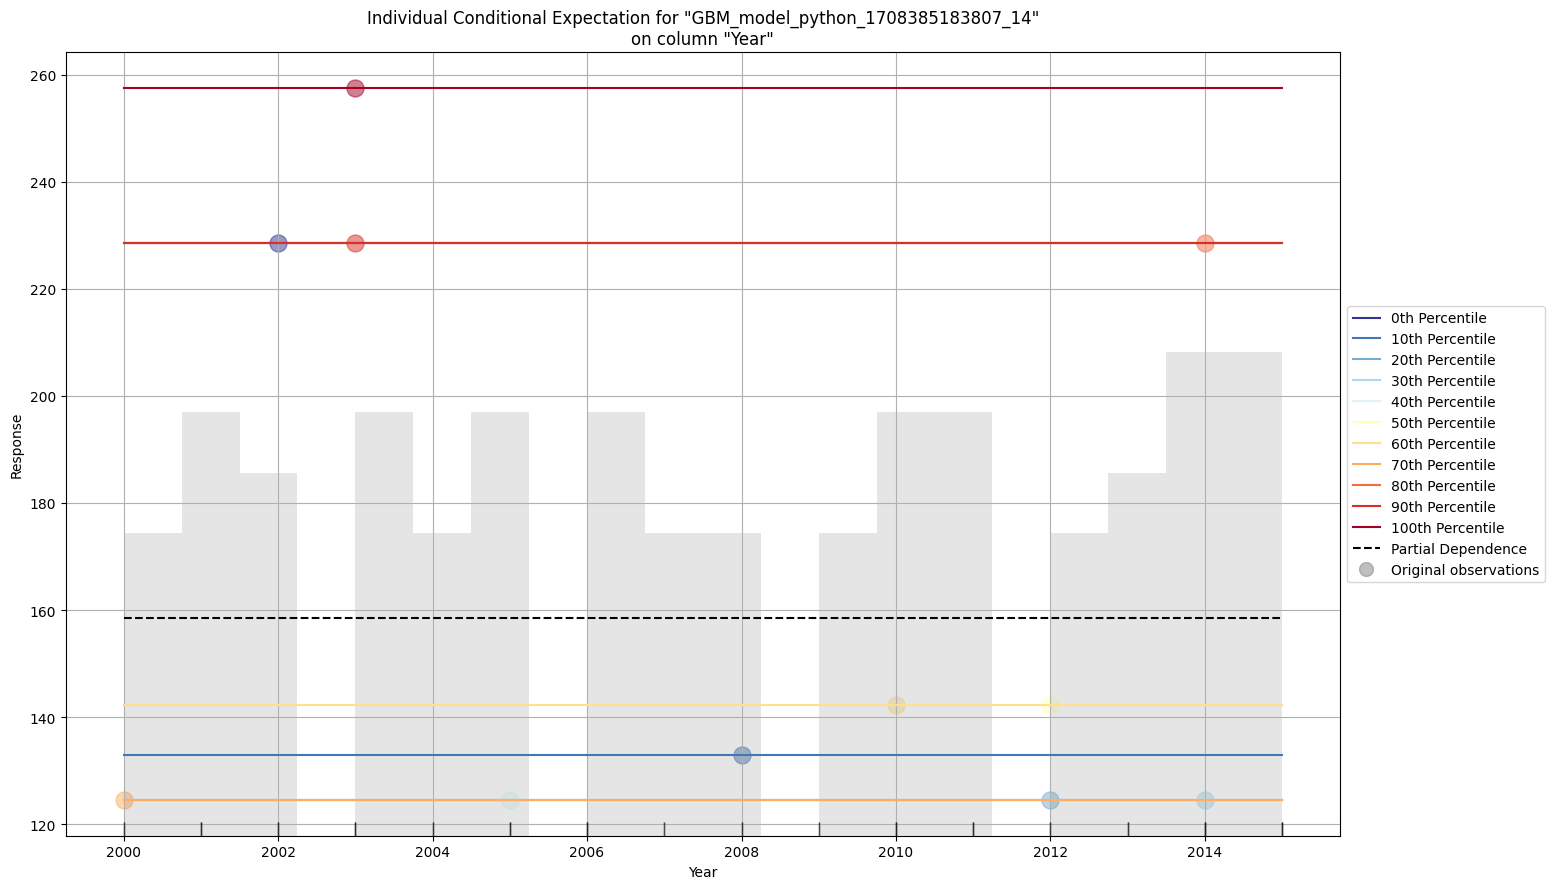

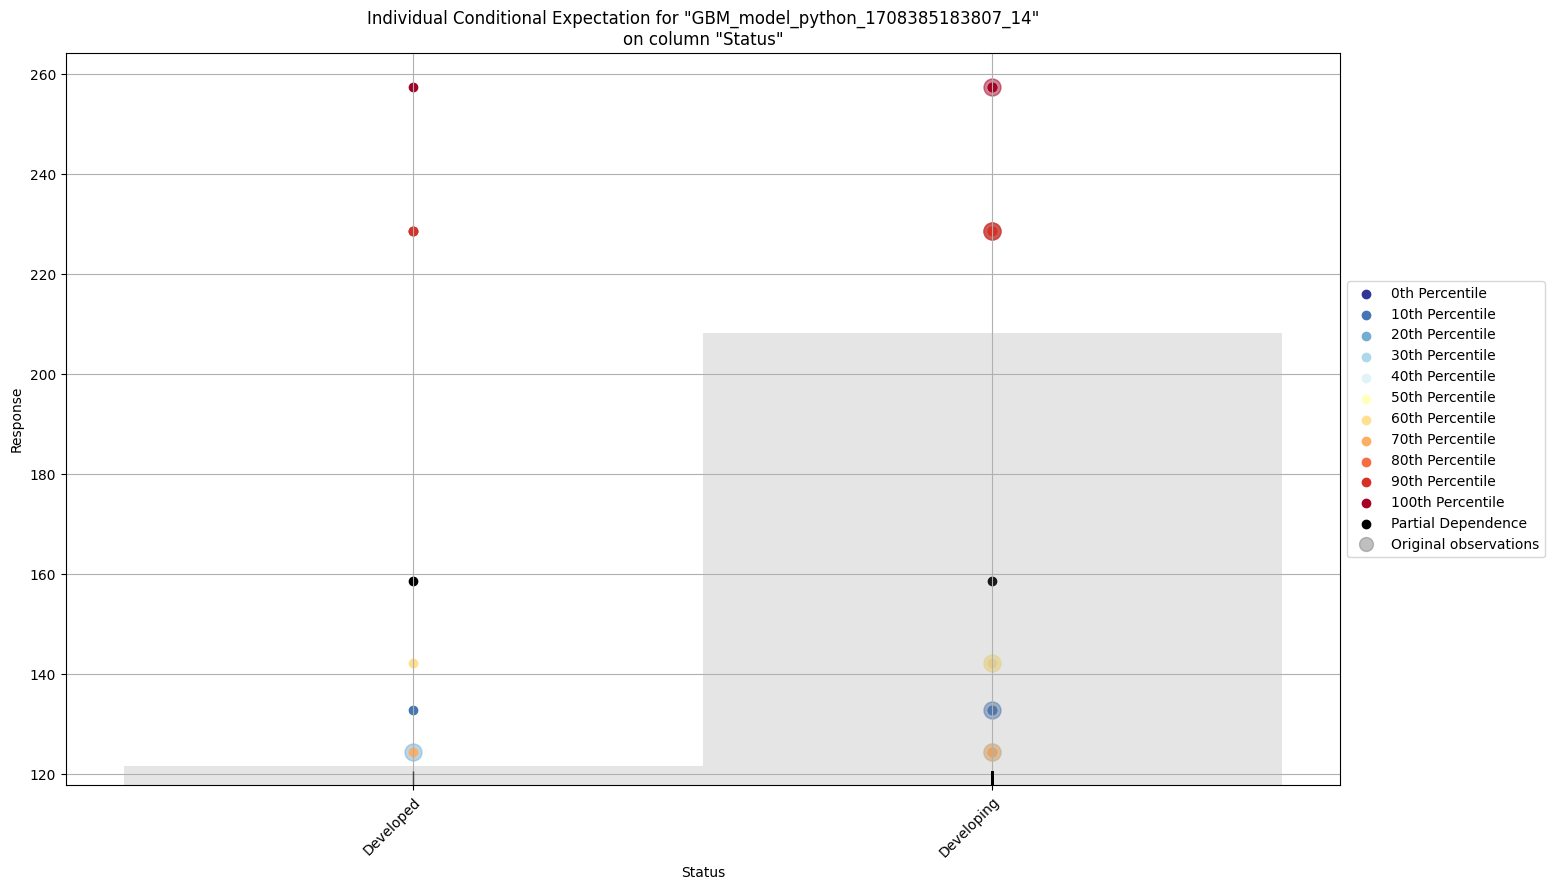

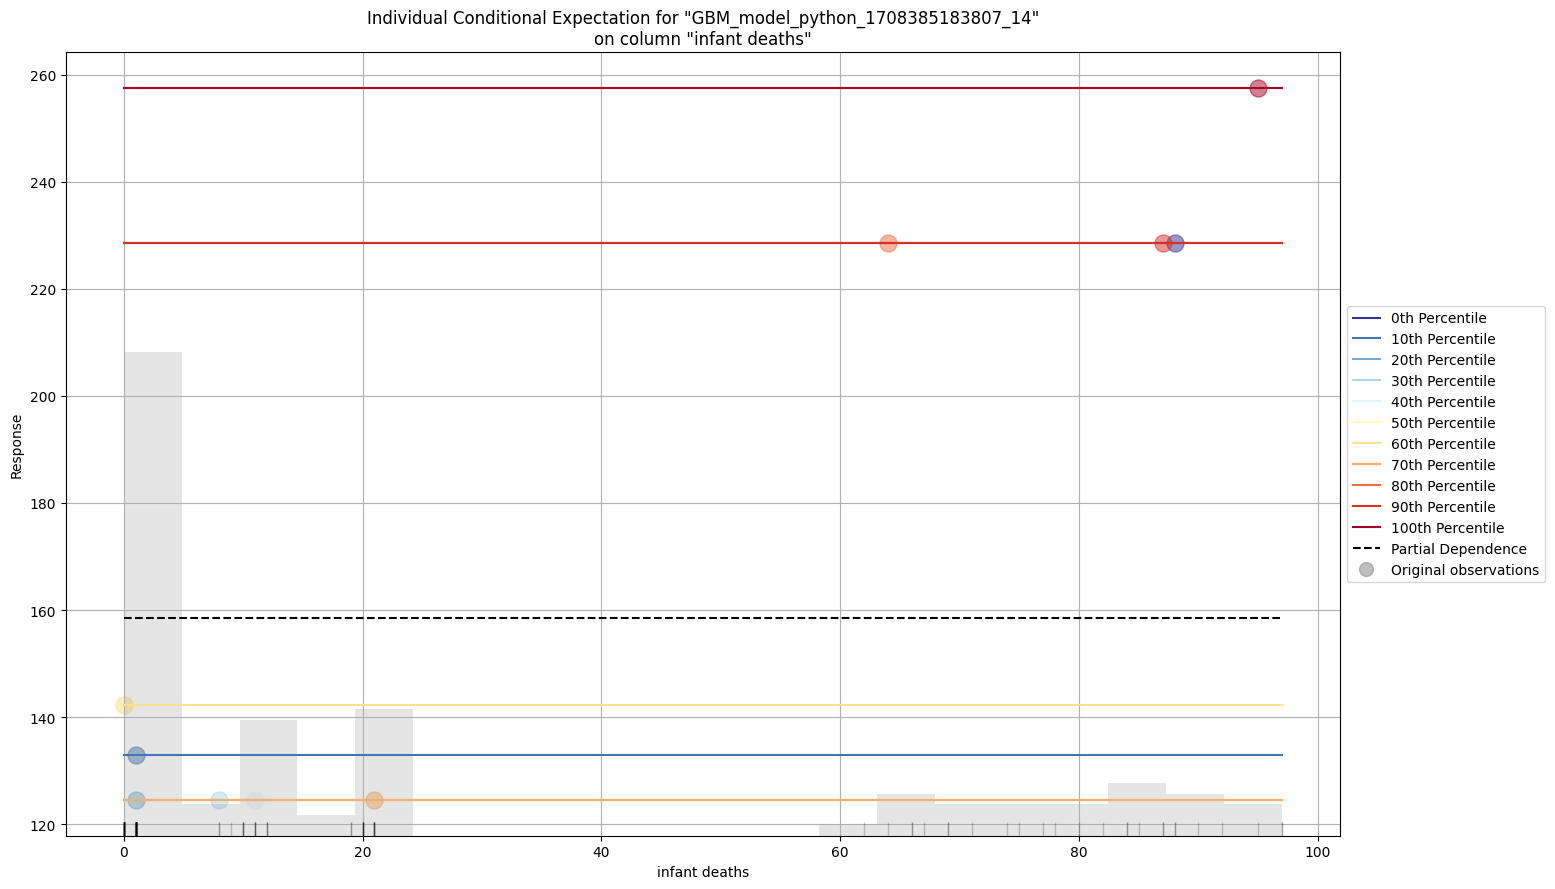

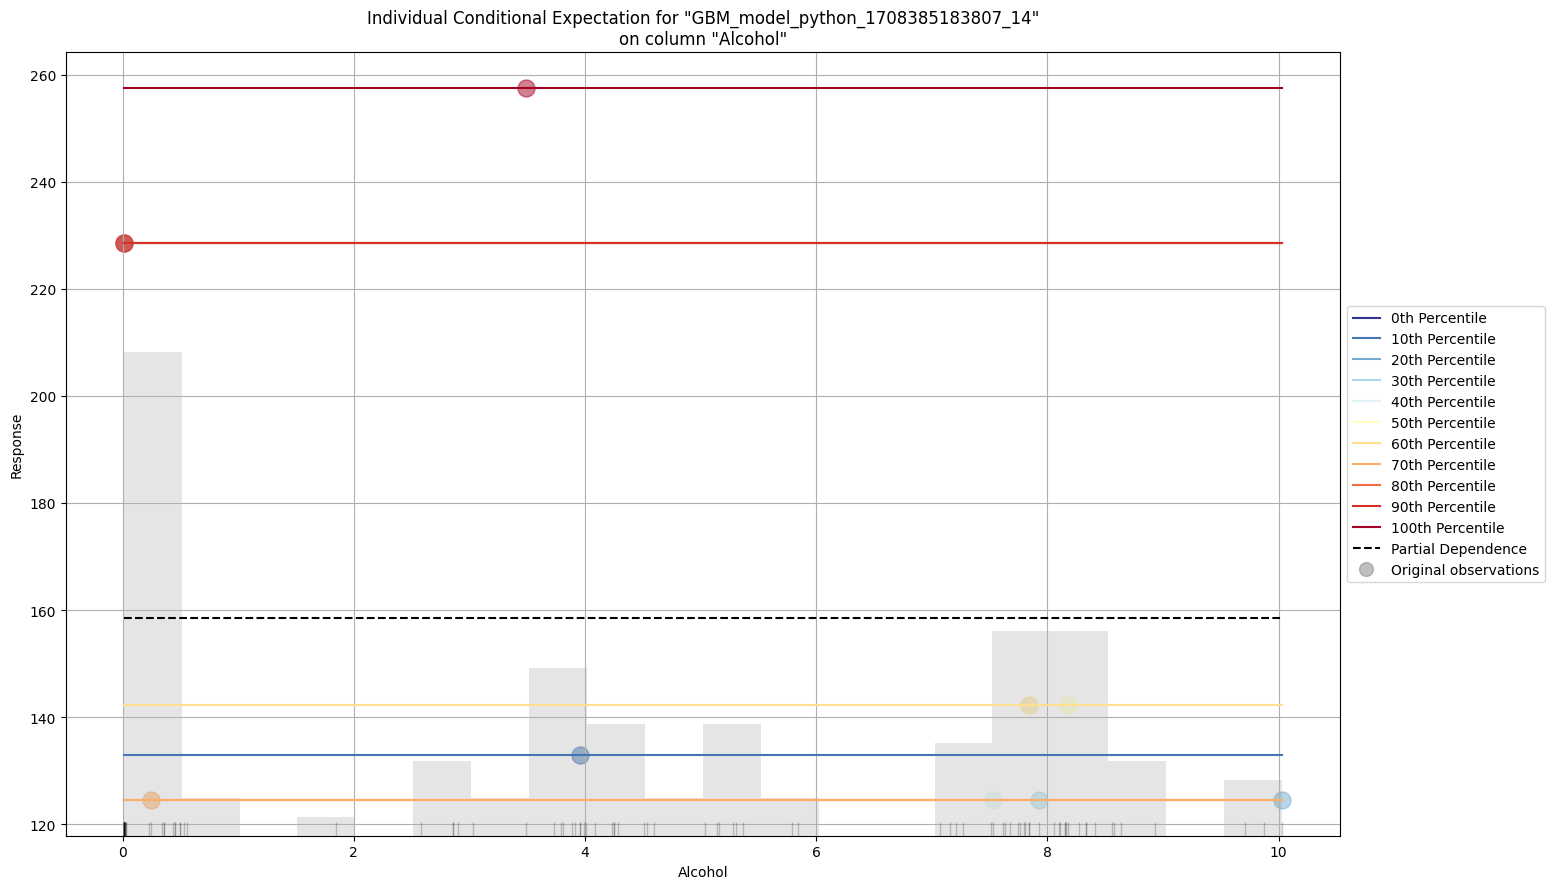

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

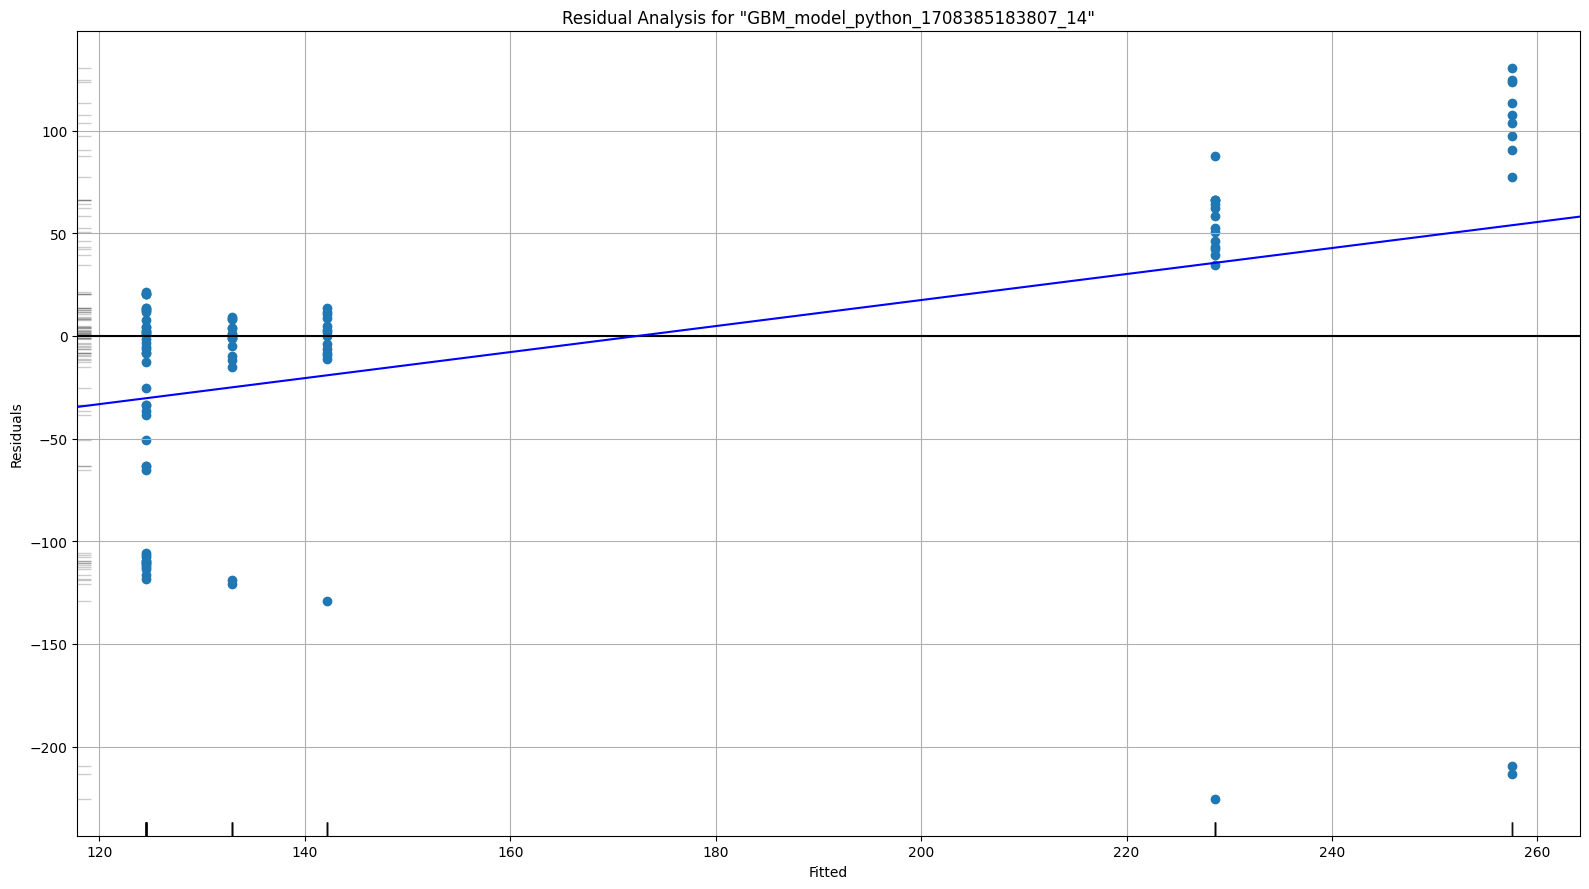

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

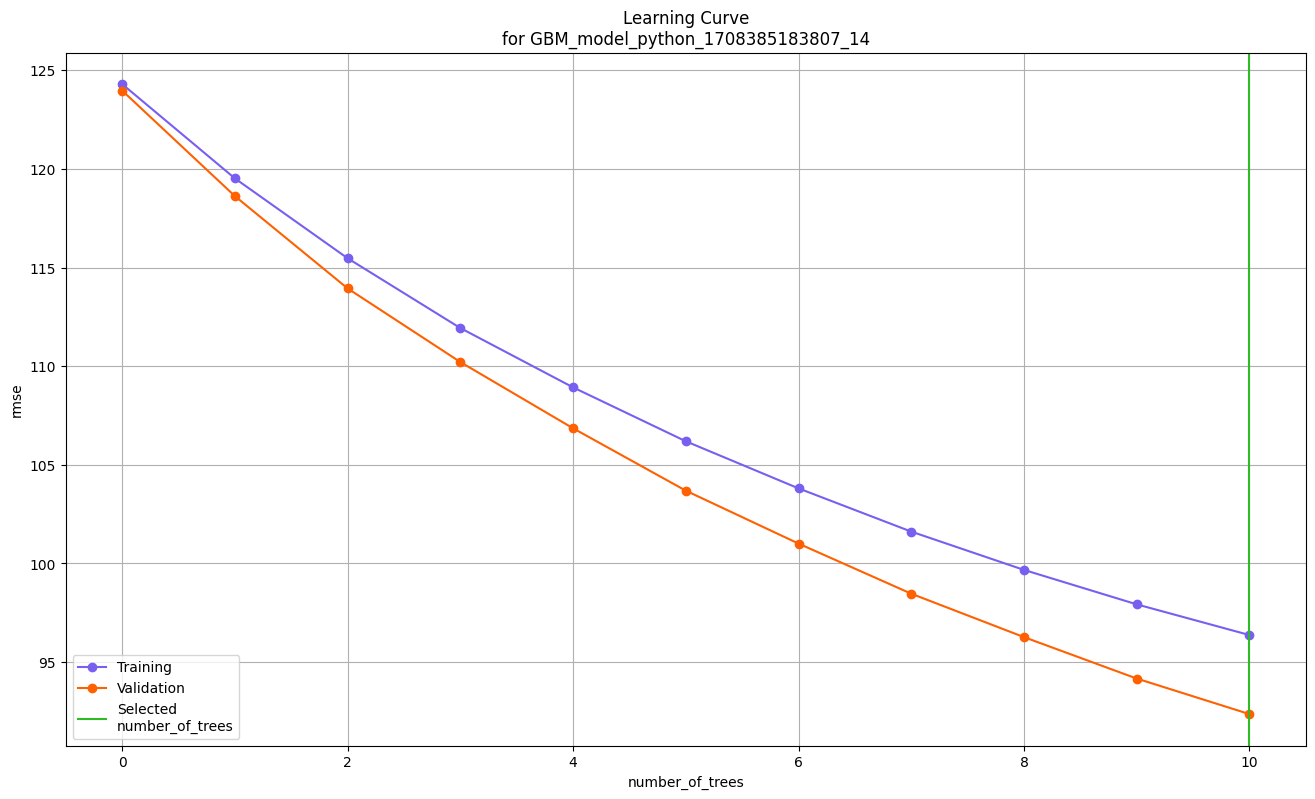

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

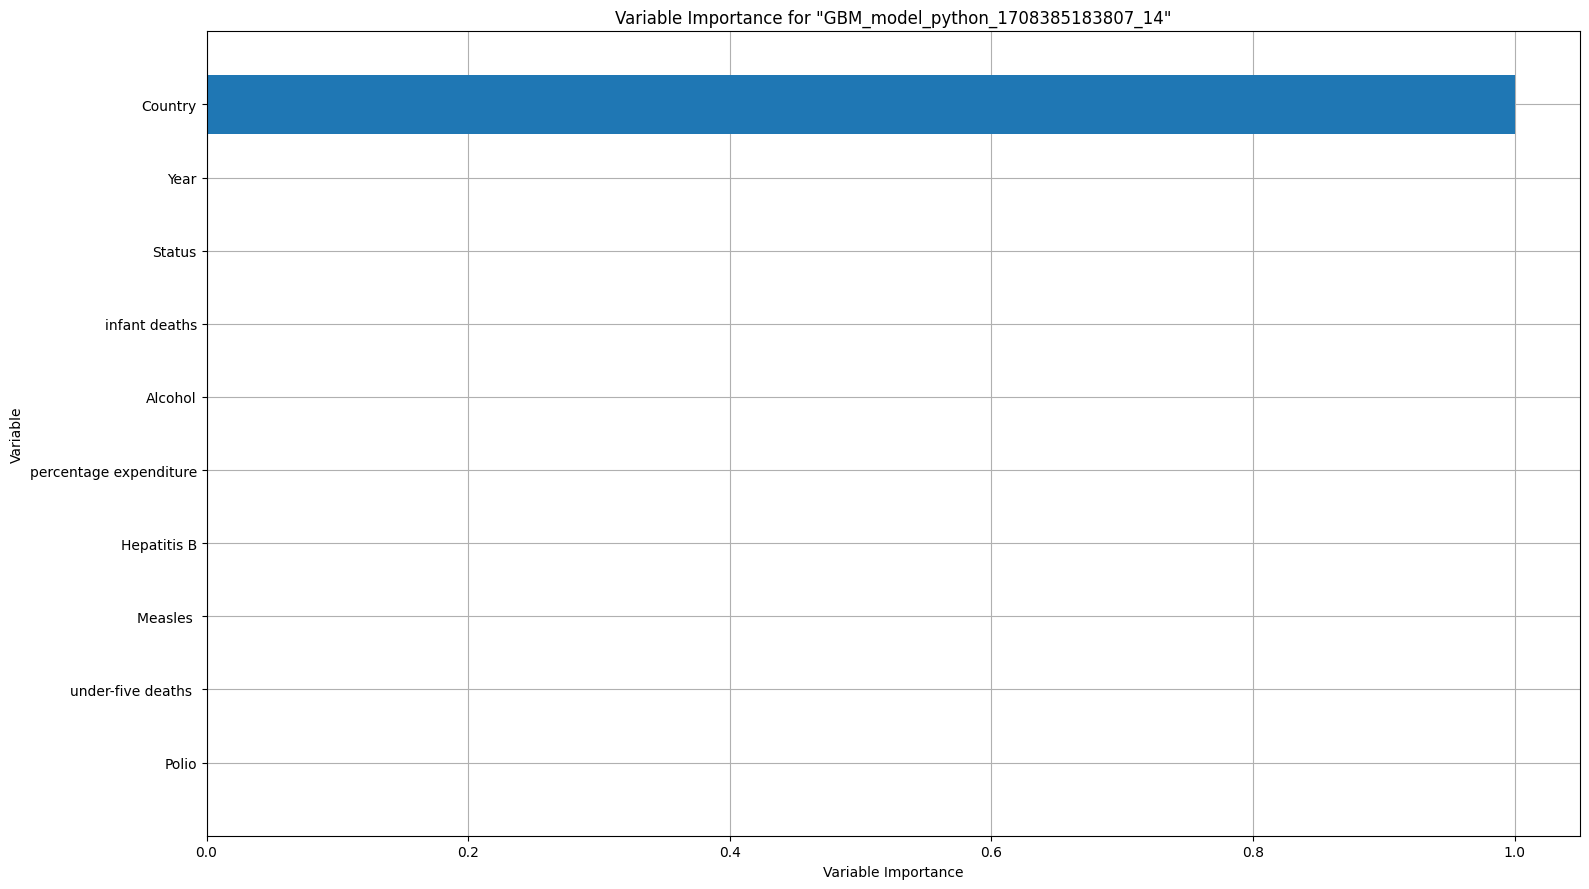

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

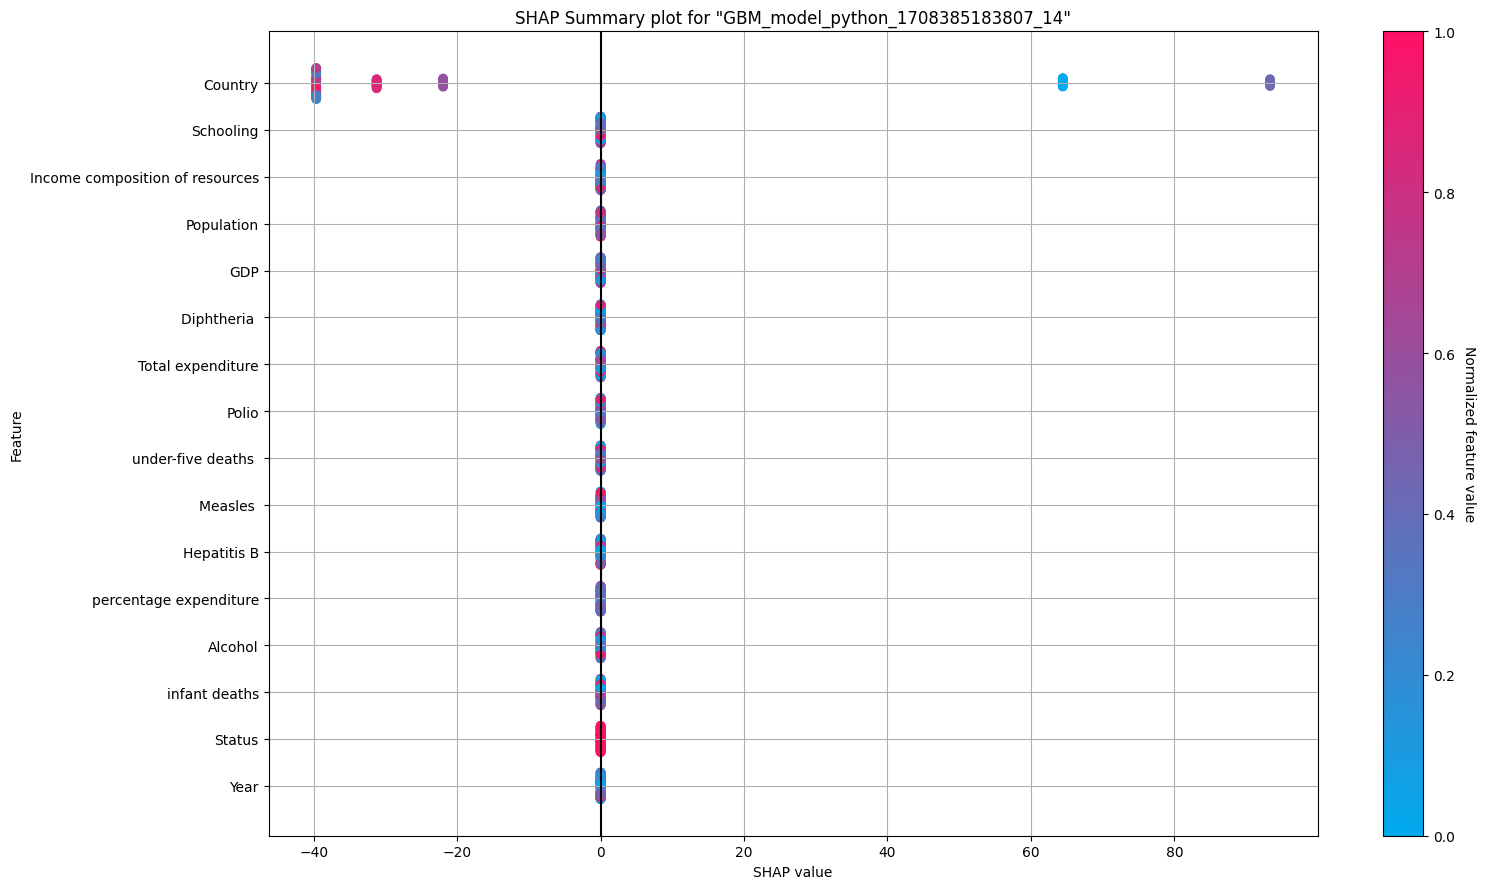

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

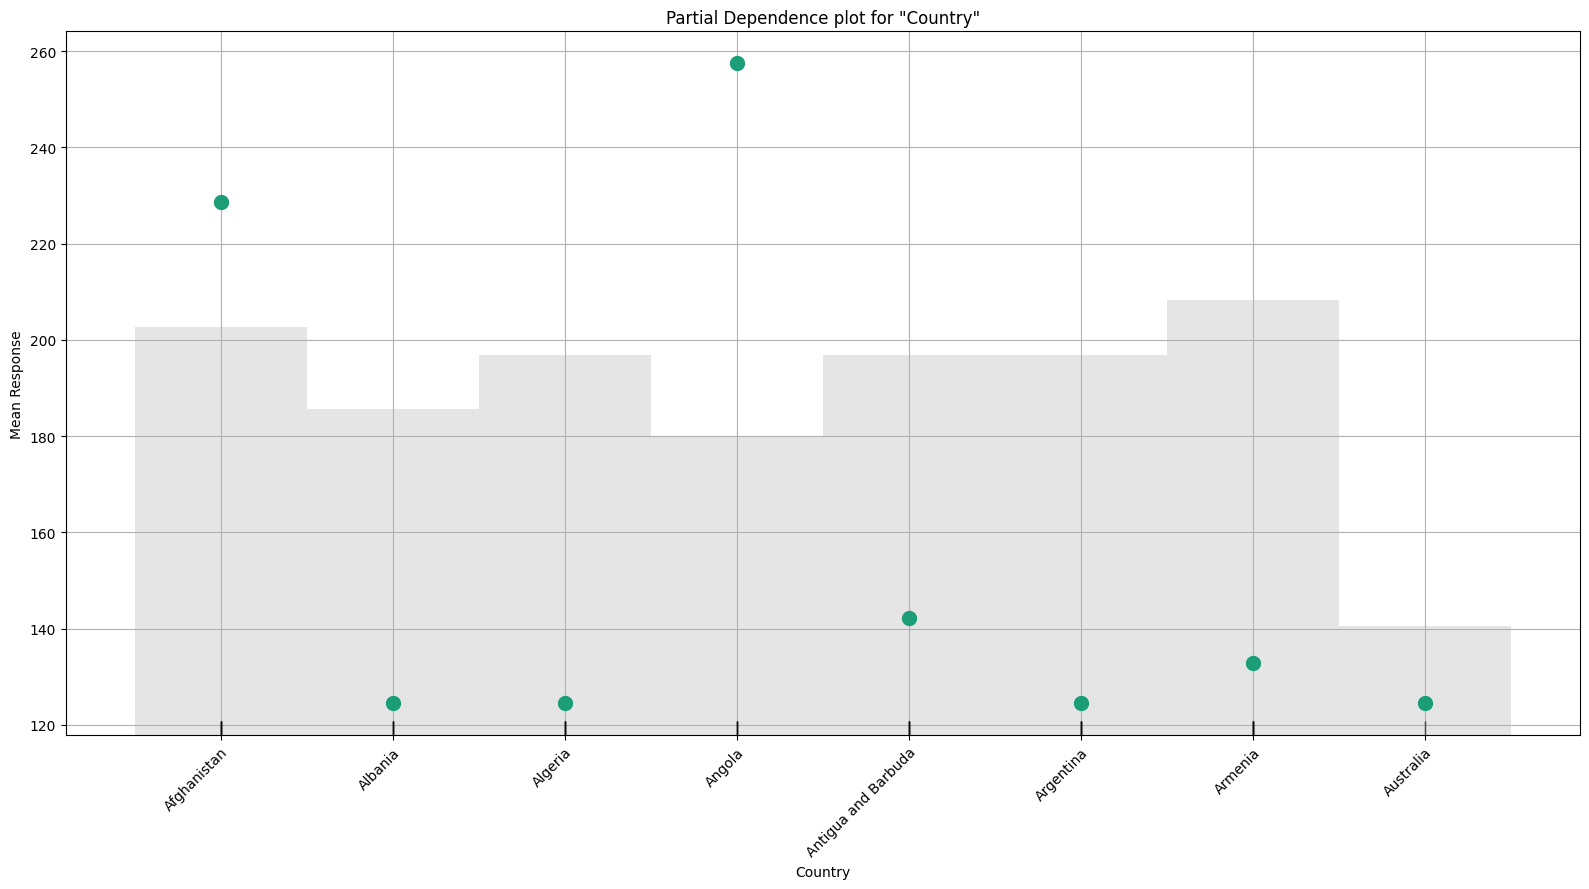

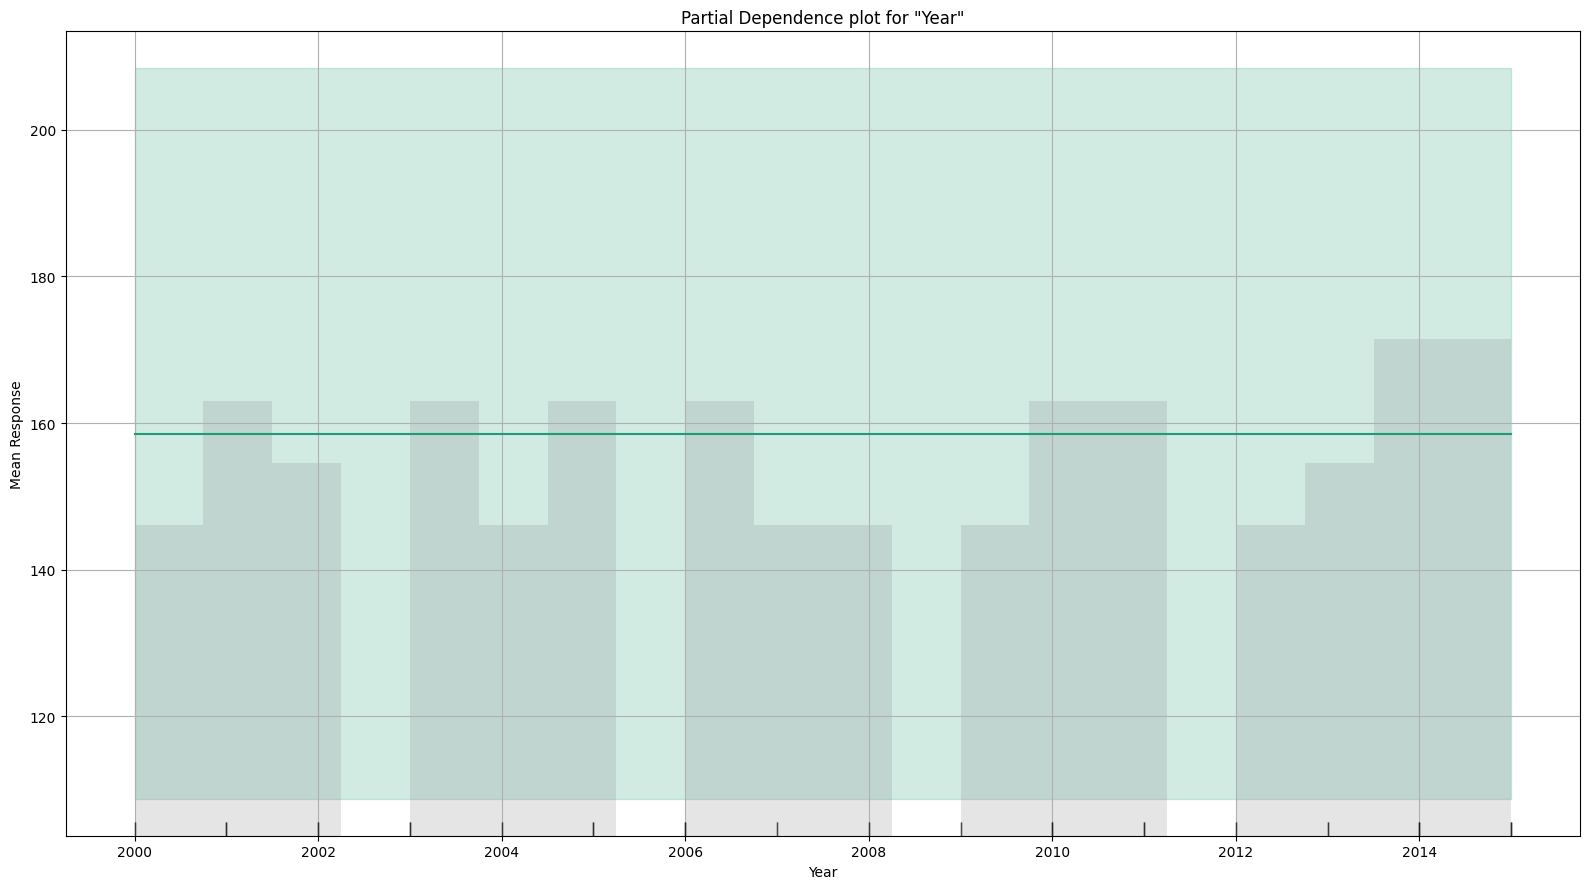

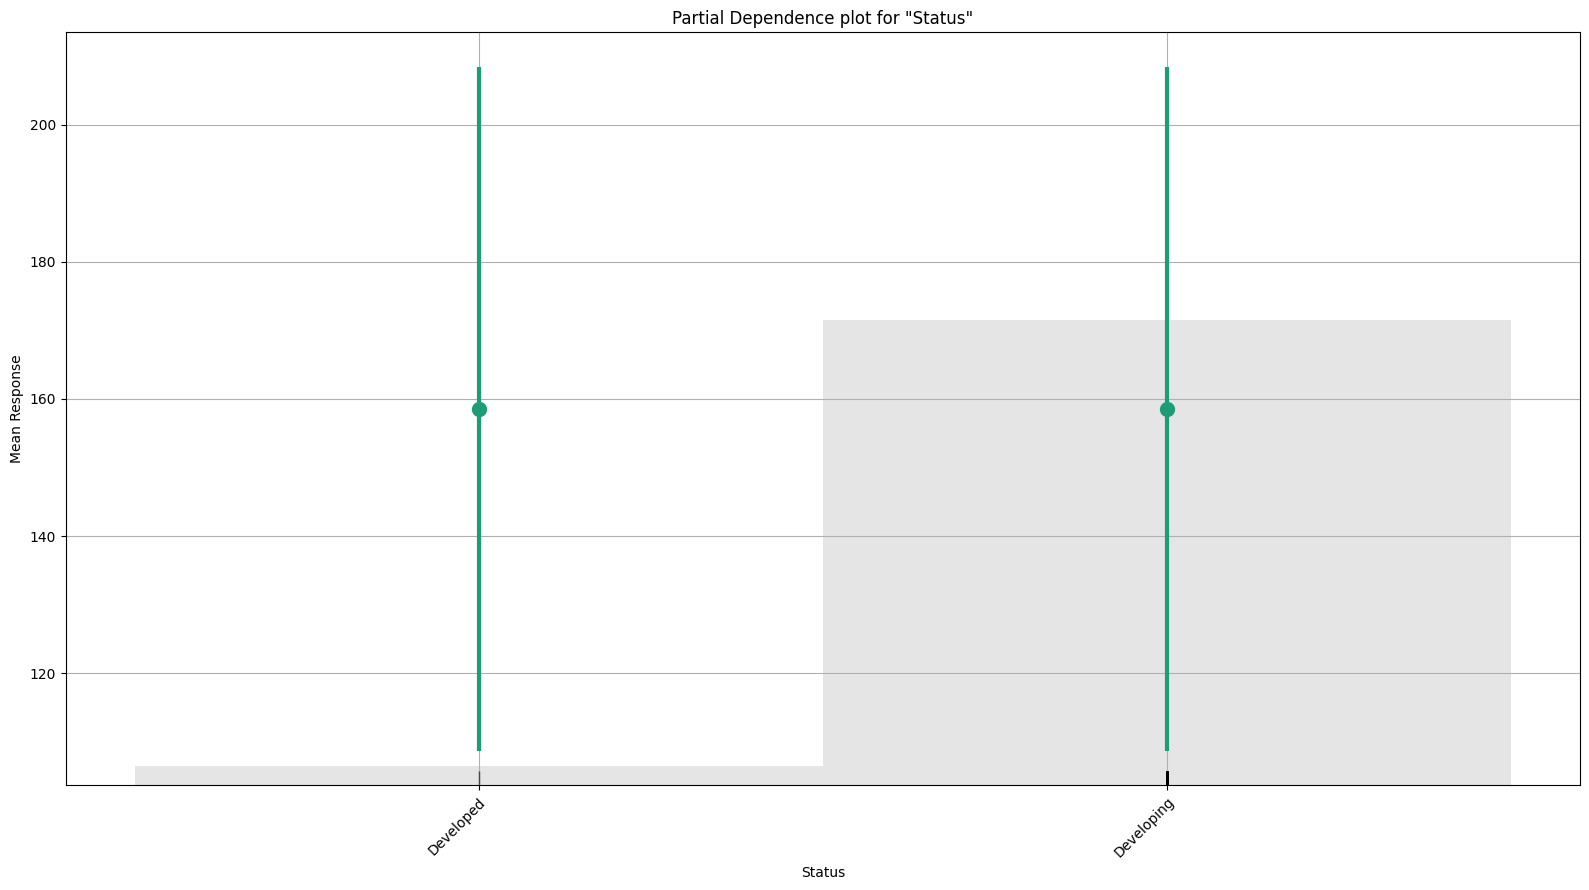

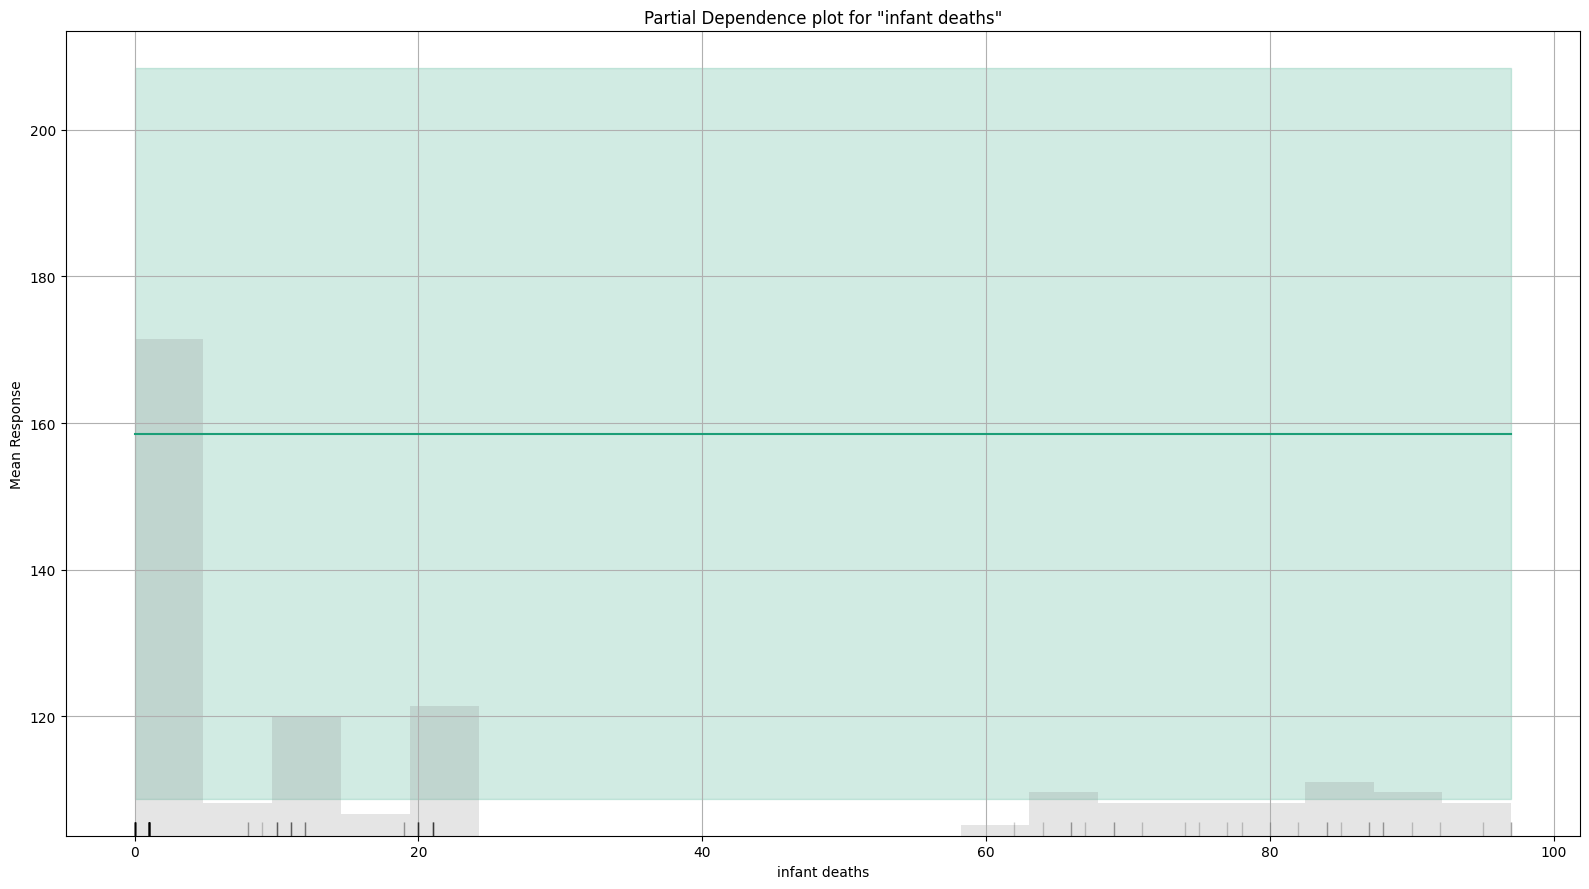

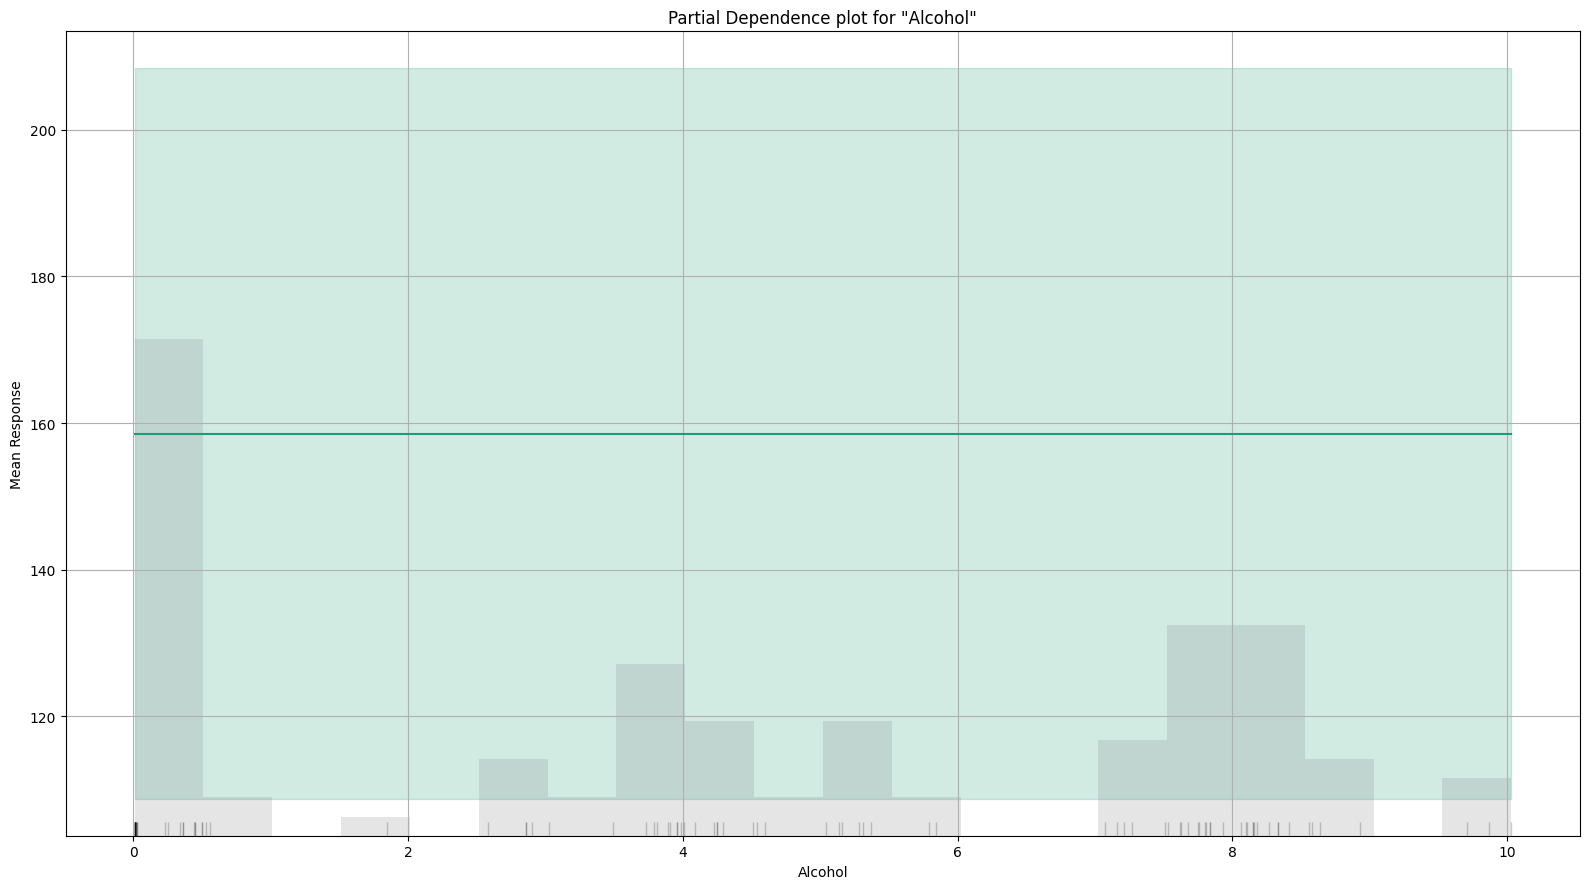

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

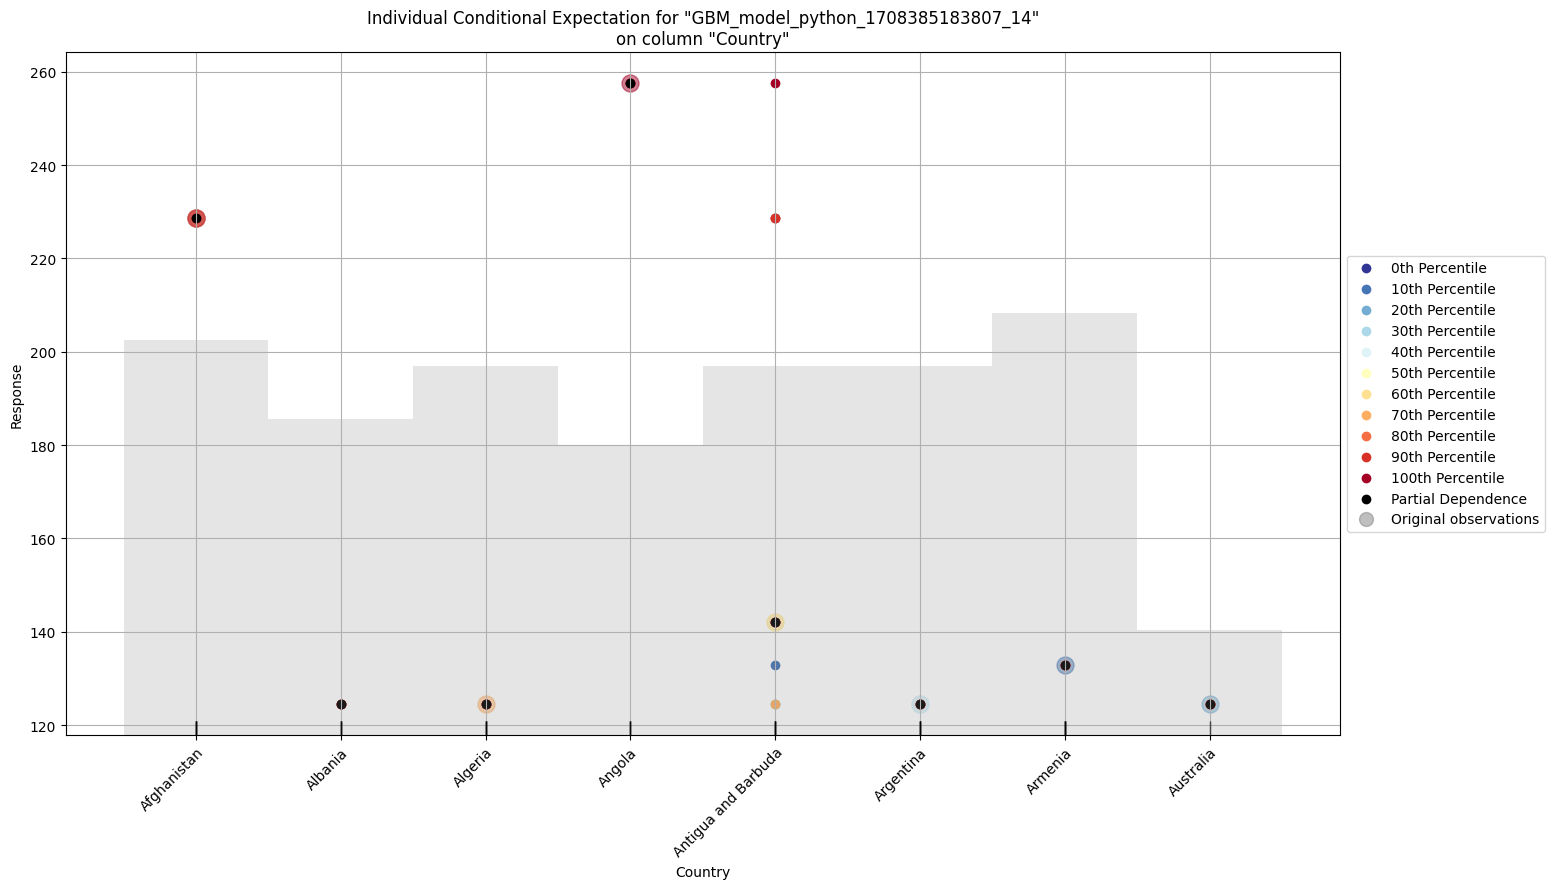

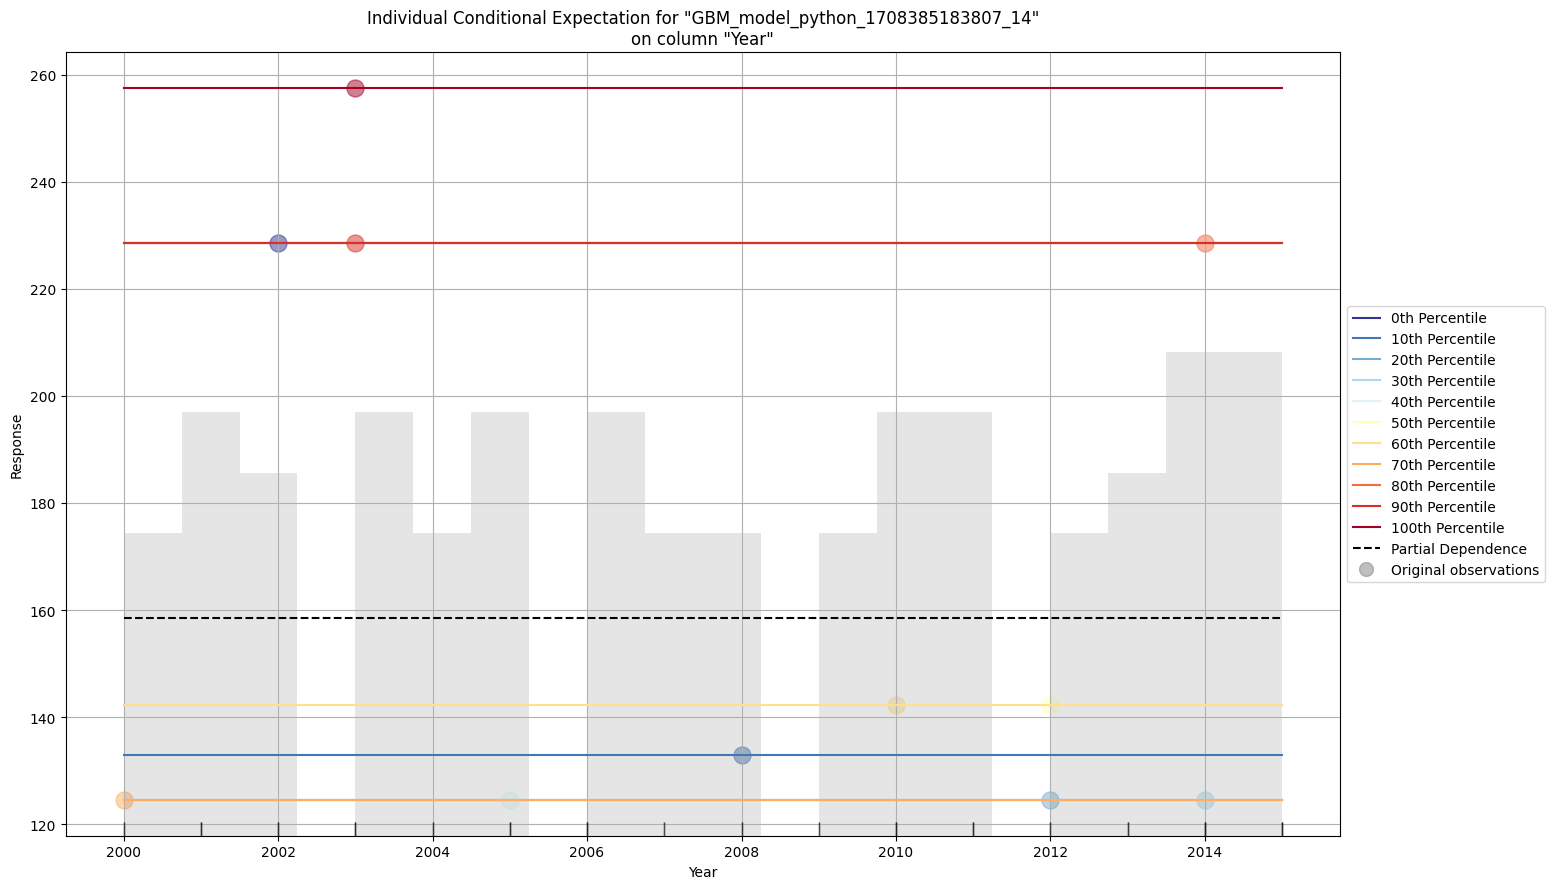

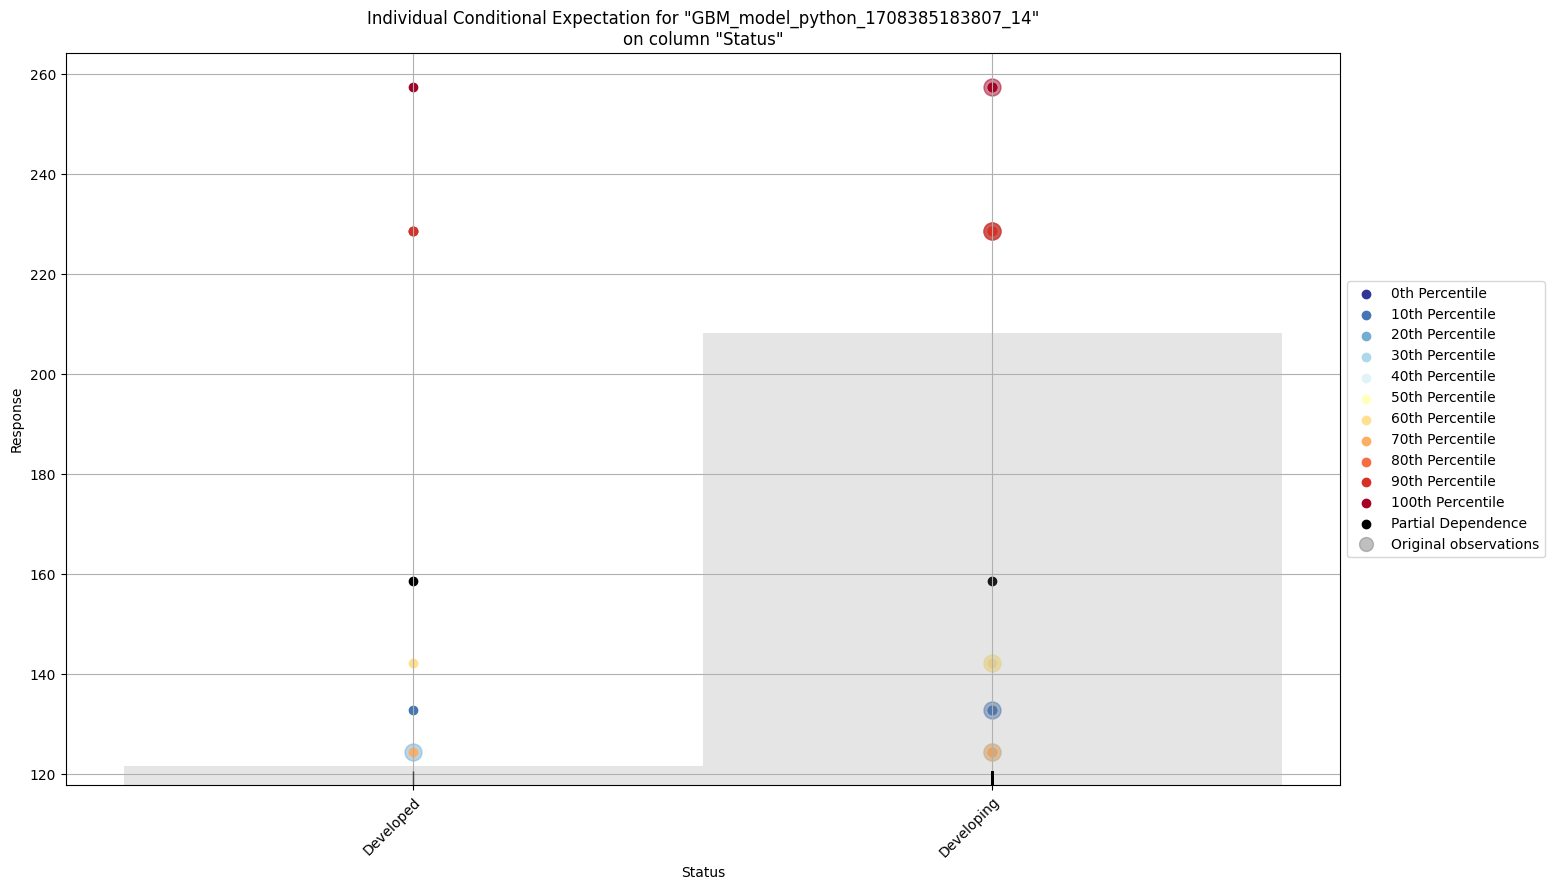

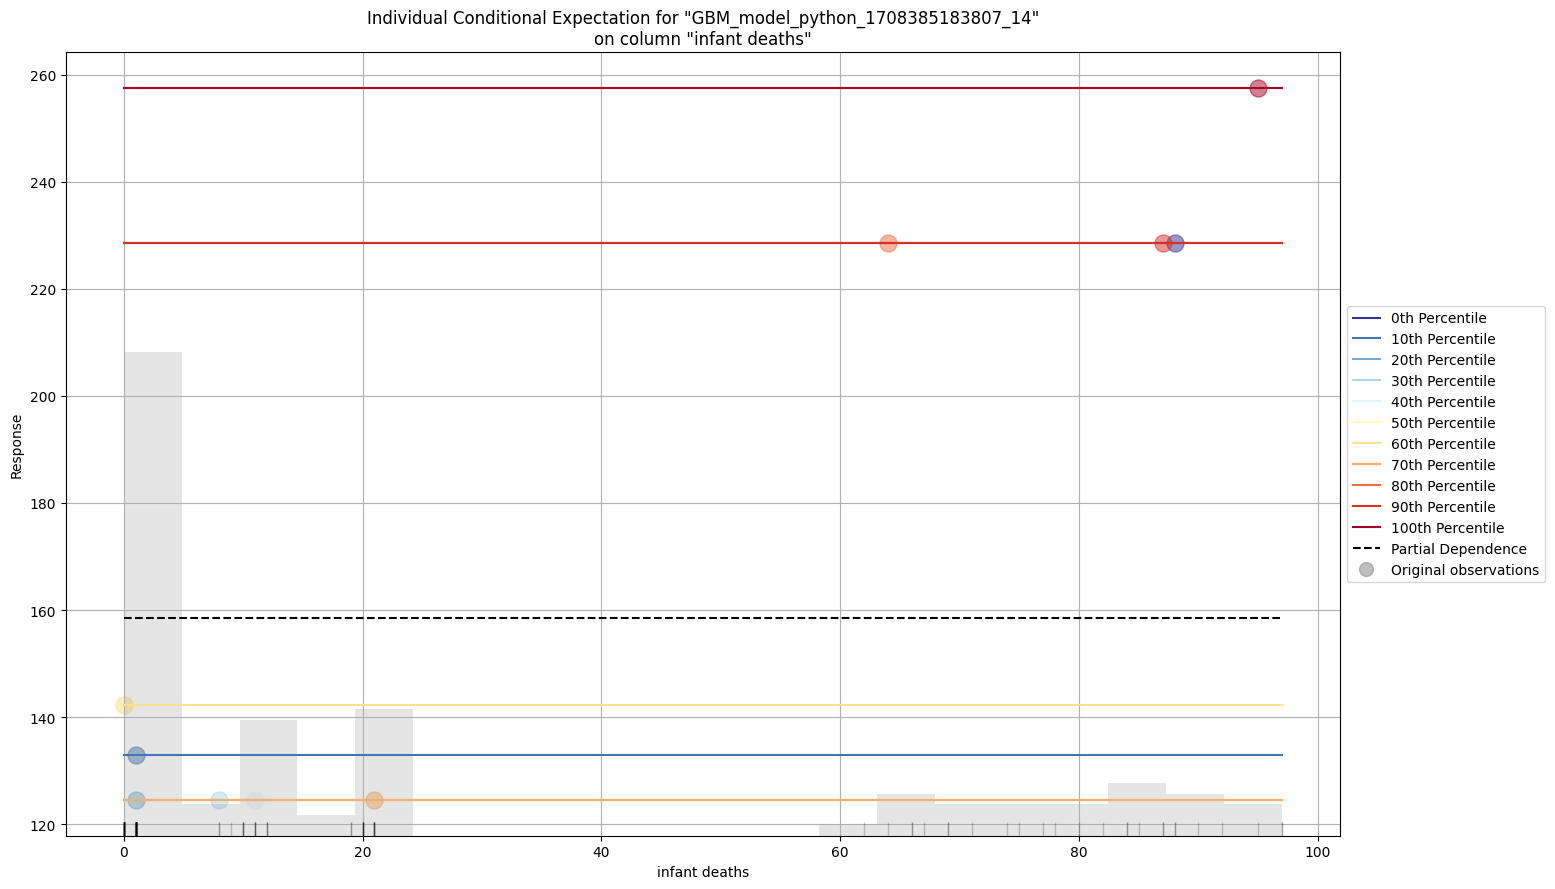

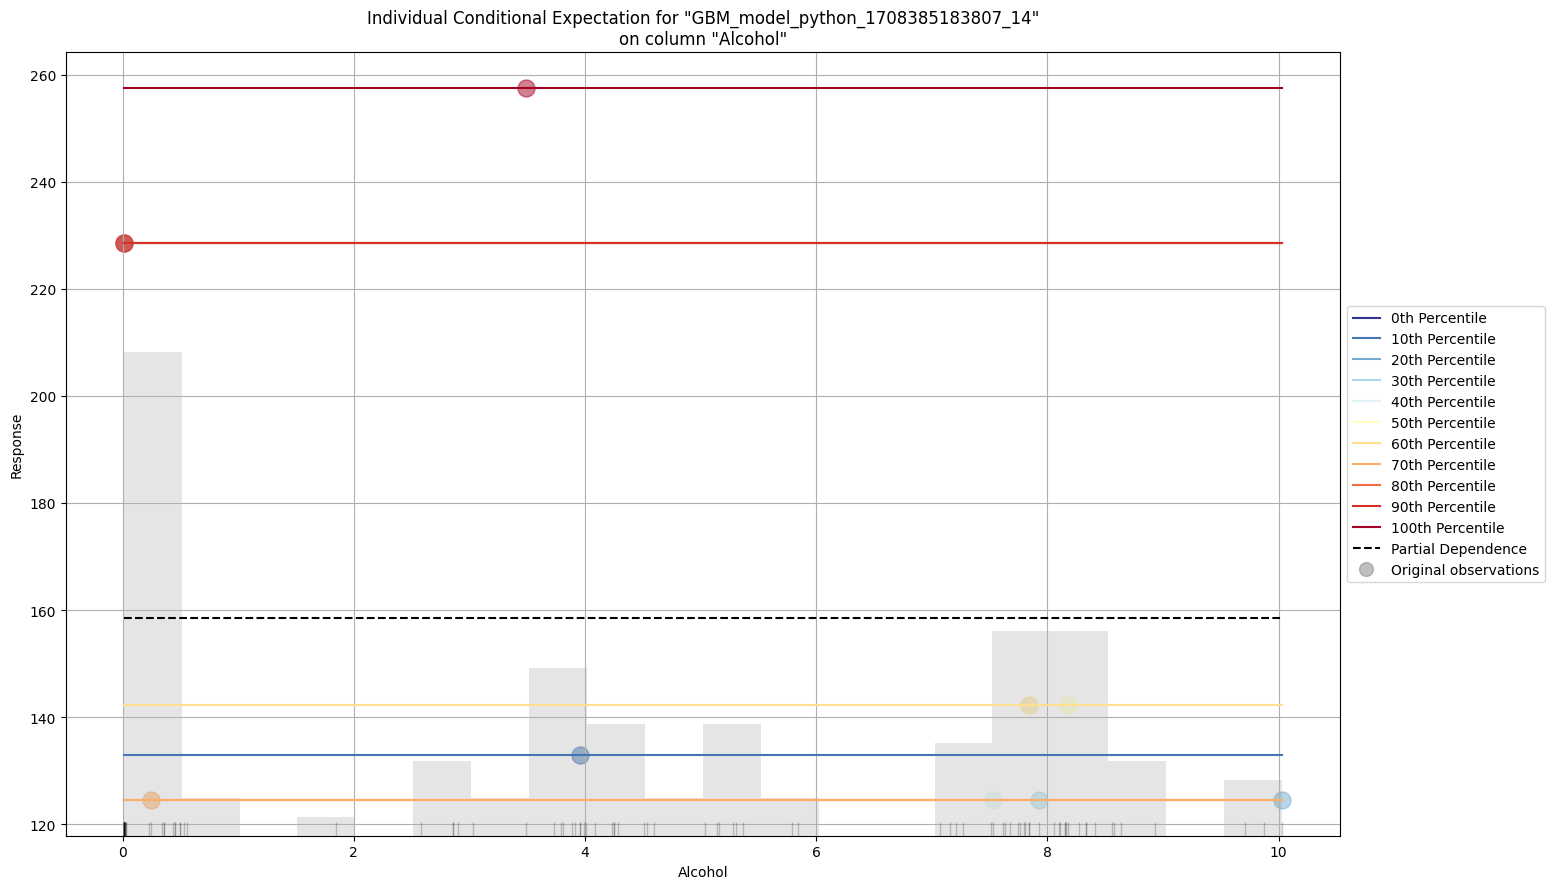

In [51]:
data_gbm.explain(train[0:100,:])


**Variable Importance in both models**

Coef_norm ;- As name says it gives you coefficient normalization of GLM model. Which are the coefficients divided by the standard deviation of the corresponding predictor variable. Normalizing the coefficients allows you to compare the relative importance of the predictors in the model, regardless of their scale or units.And glm_varimp will have tabular data of normalized coefficientsPlease note it returns an absolute values.So basically this table will give you most important variables in your GLM Model H2O GLM, the "intercept" refers to the model's bias term. The intercept is a constant term that is added to the linear combination of input features to shift the output of the model.

In [52]:
# Variable importances from each algorithm
# Calculate magnitude of normalized GLM coefficients
from six import iteritems
glm_varimp = data_glm.coef_norm()
for k,v in iteritems(glm_varimp):
    glm_varimp[k] = abs(glm_varimp[k])

# Sort in descending order by magnitude
glm_sorted = sorted(glm_varimp.items(), key = operator.itemgetter(1), reverse = True)
table = tabulate(glm_sorted, headers = ["Predictor", "Normalized Coefficient"], tablefmt = "orgtbl")
print("Variable Importances:\n\n" + table)

Variable Importances:

| Predictor                                                    |   Normalized Coefficient |
|--------------------------------------------------------------+--------------------------|
| Intercept                                                    |              163.529     |
| Income composition of resources                              |                6.08732   |
| Schooling                                                    |                5.72971   |
| Polio                                                        |                3.1249    |
| Diphtheria                                                   |                2.98663   |
| GDP                                                          |                2.87601   |
| percentage expenditure                                       |                2.54035   |
| Alcohol                                                      |                1.31387   |
| Status.Developing                                      

In [53]:
data_glm.varimp()

[('Income composition of resources',
  6.087318420410156,
  1.0,
  0.21232401216362834),
 ('Schooling', 5.7297139167785645, 0.9412541814089139, 0.19985086426253226),
 ('Polio', 3.1249029636383057, 0.5133463945570558, 0.10899576612208707),
 ('Diphtheria ', 2.9866347312927246, 0.4906322497076617, 0.1041730077547979),
 ('GDP', 2.8760135173797607, 0.4724598450011719, 0.10031456987685478),
 ('percentage expenditure',
  2.540348529815674,
  0.41731816119527193,
  0.08860666633372793),
 ('Alcohol', 1.3138693571090698, 0.21583713326114176, 0.045827406107901335),
 ('Status.Developing',
  0.9882354140281677,
  0.16234330879007666,
  0.03446938267022791),
 ('Status.Developed',
  0.9882352352142334,
  0.1623432794152482,
  0.034469376433246476),
 ('Hepatitis B', 0.9033134579658508, 0.14839267401178377, 0.03150732792187131),
 ('Total expenditure',
  0.4570106565952301,
  0.07507585853615281,
  0.01594040750102495),
 ('under-five deaths ',
  0.39109450578689575,
  0.06424742042006475,
  0.0136412700

In [54]:
data_gbm.varimp()

[('Country', 85140968.0, 1.0, 1.0),
 ('Year', 0.0, 0.0, 0.0),
 ('Status', 0.0, 0.0, 0.0),
 ('infant deaths', 0.0, 0.0, 0.0),
 ('Alcohol', 0.0, 0.0, 0.0),
 ('percentage expenditure', 0.0, 0.0, 0.0),
 ('Hepatitis B', 0.0, 0.0, 0.0),
 ('Measles ', 0.0, 0.0, 0.0),
 ('under-five deaths ', 0.0, 0.0, 0.0),
 ('Polio', 0.0, 0.0, 0.0),
 ('Total expenditure', 0.0, 0.0, 0.0),
 ('Diphtheria ', 0.0, 0.0, 0.0),
 ('GDP', 0.0, 0.0, 0.0),
 ('Population', 0.0, 0.0, 0.0),
 ('Income composition of resources', 0.0, 0.0, 0.0),
 ('Schooling', 0.0, 0.0, 0.0)]

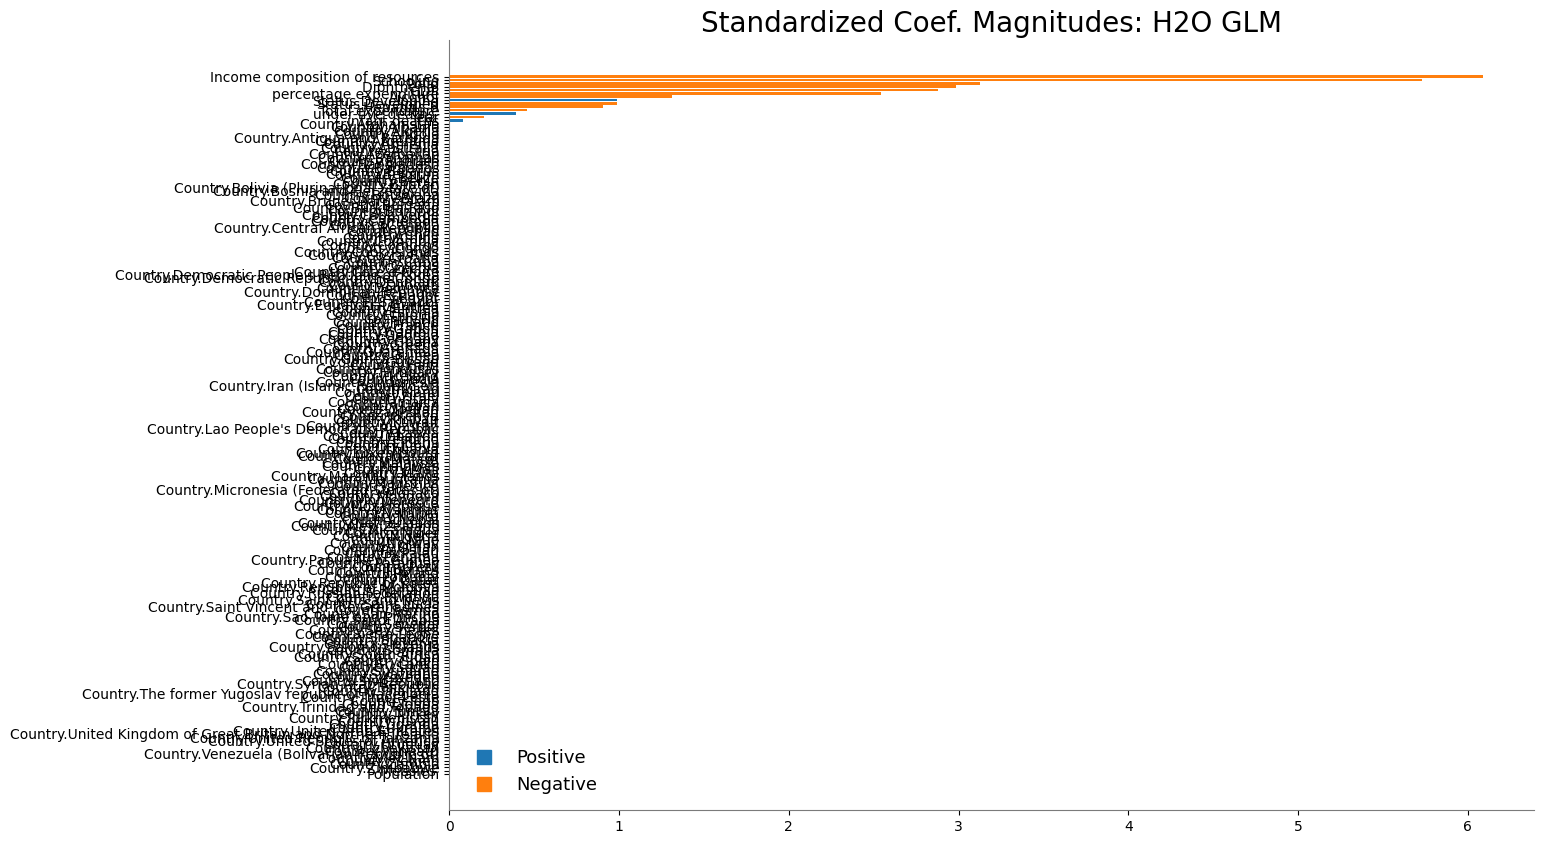

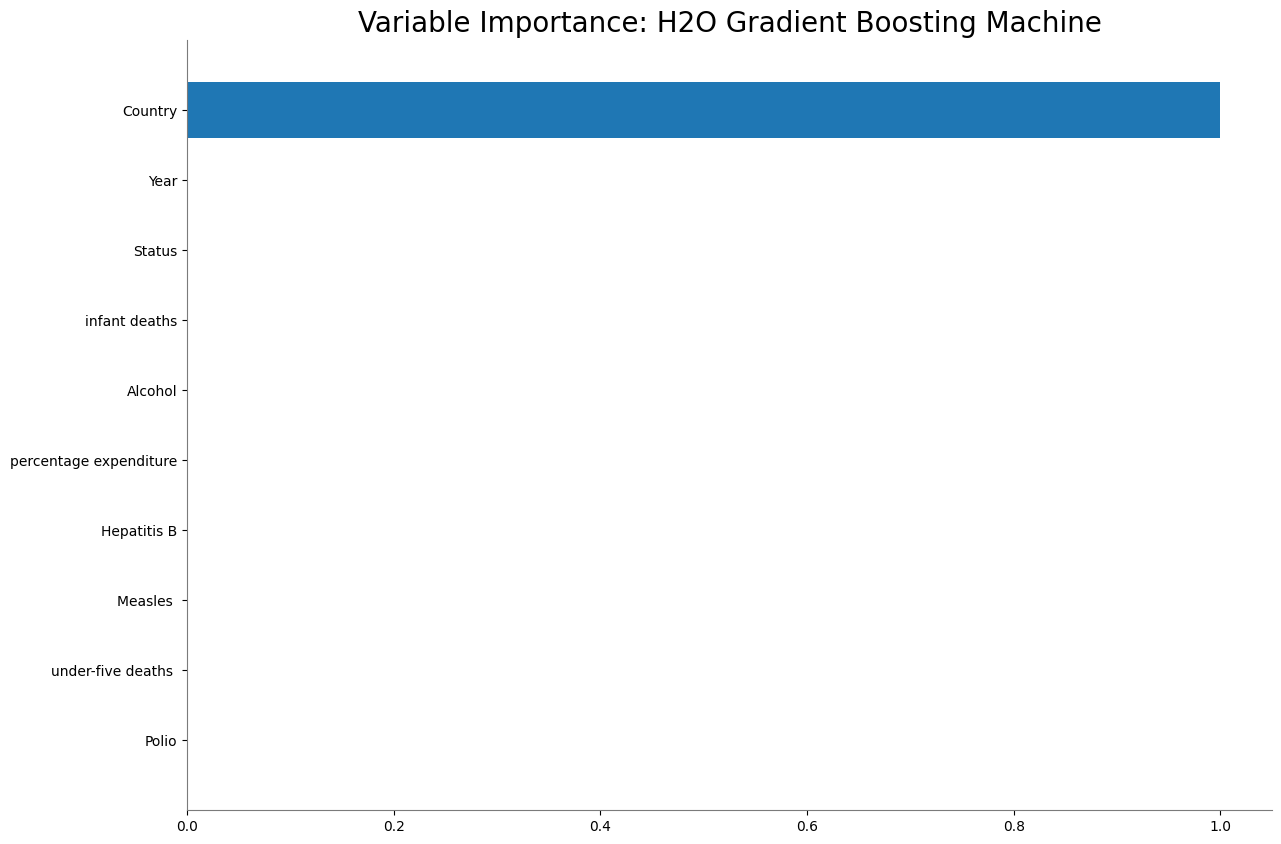

<Figure size 640x480 with 0 Axes>

In [55]:
data_glm.std_coef_plot()
data_gbm.varimp_plot()

# Model Performances


In [56]:
# Model performance of GBM model on test data
data_gbm.model_performance(test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 8530.752576032928
RMSE: 92.36207325538405
MAE: 66.99521576868554
RMSLE: 0.9846383274015935
Mean Residual Deviance: 8530.752576032928

In [57]:
data_glm.model_performance(test)


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 13298.418496572118
RMSE: 115.31876905591785
MAE: 87.55168266862002
RMSLE: 1.0767396991895315
Mean Residual Deviance: 13298.418496572118
R^2: 0.13265361278015408
Null degrees of freedom: 303
Residual degrees of freedom: 289
Null deviance: 4672661.523312016
Residual deviance: 4042719.222957924
AIC: 3781.316348909065

**Before starting Auto ML**

Before running an H2O AutoML process, it is often a good idea to run some basic modeling experiments to get a better understanding of the dataset and the modeling problem. Two commonly used algorithms for this purpose are the H2O Generalized Linear Model (GLM) and Gradient Boosting Machine (GBM).

The H2O GLM is a linear model that is well-suited for datasets with a relatively small number of features and a linear relationship between the features and the target variable. The GLM is also useful for quickly identifying which input features are most important in predicting the target variable.

The H2O GBM is a tree-based ensemble learning algorithm that can be used for both classification and regression problems. The GBM is well-suited for datasets with many features and complex relationships between the features and the target variable. The GBM can also be used to identify important features in the dataset.

By running GLM and GBM experiments on the dataset before running an H2O AutoML process, you can gain a better understanding of the data and the modeling problem. Specifically, you can:

Identify which features are most important for predicting the target variable
Determine which algorithms are well-suited for the problem
Get a sense of the performance of these algorithms on the dataset
Use the results of the experiments to inform your selection of algorithms and features in the AutoML process.
Overall, running some basic modeling experiments before using H2O AutoML can help you make more informed modeling decisions and improve the performance of your final model.

# AutoML Best Algo


In [58]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ and name !='Happiness rank']
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:

            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)
            else:
                reals.append(key)
    x=ints+enums+reals
    return x

In [59]:
#print(train)
#print(train.columns)
X=get_independent_variables(train, myY)
print(X)
print(myY)

['Year', 'infant deaths', 'Hepatitis B', 'Measles ', 'under-five deaths ', 'Polio', 'Diphtheria ', 'Country', 'Status', 'Alcohol', 'percentage expenditure', 'Total expenditure', 'GDP', 'Population', 'Income composition of resources', 'Schooling']
Adult Mortality


In [60]:
# Set up AutoML
run_time=333
aml = H2OAutoML(max_runtime_secs=run_time)

In [61]:
model_start_time = time.time()

aml.train(x=X,y=myY,training_frame=train)

AutoML progress: |
00:26:38.937: XGBoost_1_AutoML_1_20240220_02638 [XGBoost def_2] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_1_AutoML_1_20240220_02638_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.


████
00:26:51.222: XGBoost_2_AutoML_1_20240220_02638 [XGBoost def_1] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_2_AutoML_1_20240220_02638_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.


█████
00:27:25.638: XGBoost_3_AutoML_1_20240220_02638 [XGBoost def_3] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_3_AutoML_1_20240220_02638_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.


██████


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20240220_02638


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       12/44
# GBM base models (used / total)           9/38
# DRF base models (used / total)           1/2
# DeepLearning base models (used / total)  2/3
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 2456.353093140662
RMSE: 49.56160906529026
MAE: 29.51102273307944
RMSLE: 0.7224645454814207
Mean Residual Deviance: 2456.353093140662
R^2: 0.8410345767988876
Null degrees of freedom: 2623
Residual degrees of freedom: 2611
Null deviance: 40546367.798780486
Residual deviance: 6445470.516401097
AIC: 27958.669736271193

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 6467.222970120927
RMSE: 80.41904606572331
MAE: 47.28759147998773
RMSLE: 0.874030840893613
Mean Residual Deviance: 6467.222970120927
R^2: 0.5814669970485562
Null degrees of freedom: 2623
Residual degrees of freedom: 2610
Null deviance: 40581735.841371015
Residual deviance: 16969993.073597312
AIC: 30500.882877529508

Cross-Validation Metrics Summary: 
                        mean         sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     47.3185      1.92377    47.7452       45.0071       45.9422       49.9659       47.9318
mean_residual_deviance  6470.9       387.195    6374.74       6099.05       6132.91       6792.99       6954.83
mse                     6470.9       387.195    6374.74       6099.05       6132.91       6792.99       6954.83
null_deviance           8.11635e+06  471727     7.87639e+06   8.31953e+06   7.57751e+06   8.81356e+06   7.99475e+06
r2                      0.58047      0.0234837  0.579594      0.584226      0.596681      0.600472      0.541378
residual_deviance       3.39431e+06  228706     3.30849e+06   3.45206e+06   3.05419e+06   3.4916e+06    3.66519e+06
rmse                    80.4133      2.39923    79.8419       78.0964       78.3129       82.4196       83.3956
rmsle                   0.873763     0.0382791  0.908126      0.828383      0.835959      0.897981      0.898367

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

**Explaining output of next cell !!**

The reason why the H2O AutoML leaderboard shows a lot of stacked ensemble algorithms is because one of the primary goals of H2O AutoML is to automatically build a high-performing ensemble model from a diverse set of base models.

The process of building a stacked ensemble model involves training multiple base models on the input data, and then training a metalearning model on the predictions of the base models. The metalearning model learns how to combine the predictions of the base models in order to make more accurate predictions. The result is an ensemble model that is typically more accurate than any of the individual base models.

H2O AutoML uses a variety of base models during the training process, including deep learning models, tree-based models, and linear models. After training the base models, H2O AutoML selects the best performing models and uses them to build the stacked ensemble. The stacked ensemble is typically one of the top performing models on the leaderboard.

In general, stacked ensembles tend to perform well in many different types of predictive modeling problems, which is why H2O AutoML emphasizes their use. However, it's worth noting that the best model for a particular problem may not always be a stacked ensemble, and it's always a good idea to experiment with different models and ensembling techniques to find the best solution for a given problem.

In [62]:
print(aml.leaderboard)

model_id                                                   rmse      mse      mae     rmsle    mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20240220_02638     80.419   6467.22  47.2876  0.874031                   6467.22
StackedEnsemble_AllModels_4_AutoML_1_20240220_02638     80.5622  6490.27  47.463   0.873956                   6490.27
StackedEnsemble_AllModels_1_AutoML_1_20240220_02638     80.5868  6494.23  47.3537  0.872542                   6494.23
StackedEnsemble_BestOfFamily_2_AutoML_1_20240220_02638  80.6742  6508.33  47.3397  0.873069                   6508.33
GBM_3_AutoML_1_20240220_02638                           80.7449  6519.74  47.6947  0.871709                   6519.74
StackedEnsemble_BestOfFamily_4_AutoML_1_20240220_02638  80.7523  6520.93  47.3226  0.87248                    6520.93
StackedEnsemble_BestOfFamily_3_AutoML_1_20240220_02638  80.8059  6529.59  47.4751  0.874768                   6529.59
StackedEnsemble_AllModels_2_AutoML_1_20240220_02638     

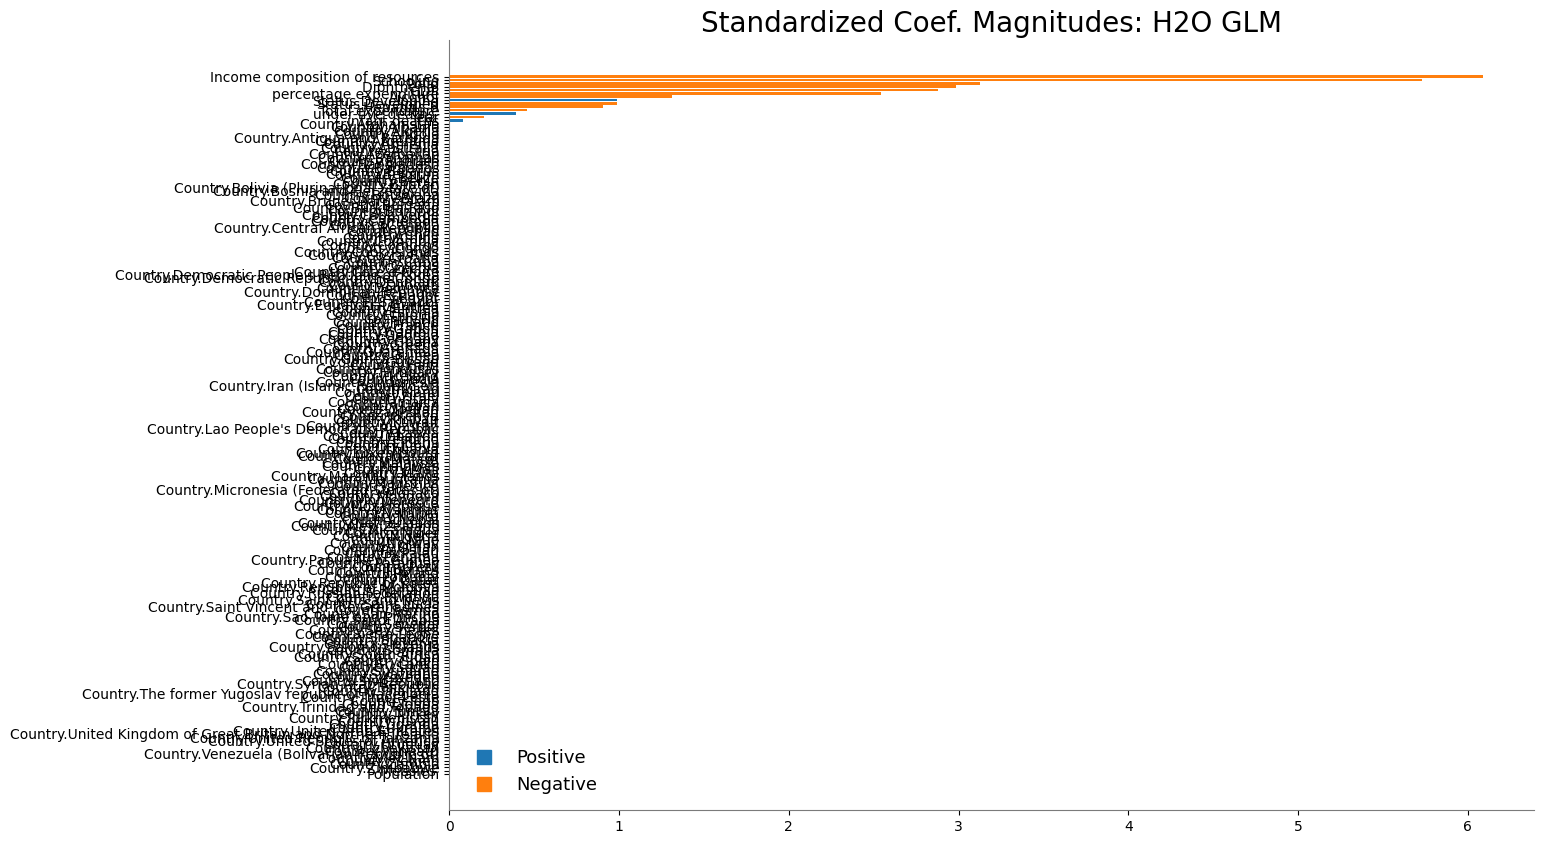

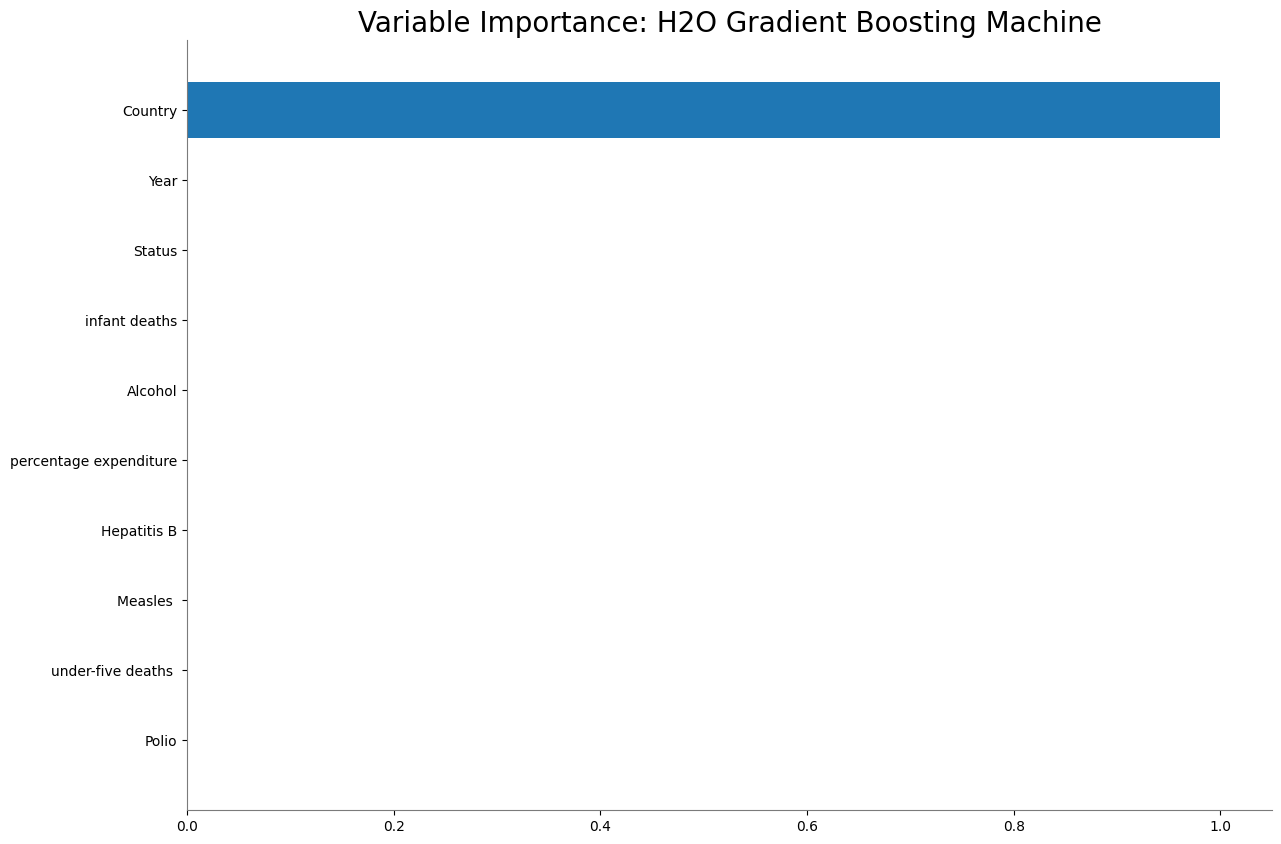

<Figure size 640x480 with 0 Axes>

In [63]:
data_glm.std_coef_plot()
data_gbm.varimp_plot()

In [64]:
best_model = h2o.get_model(aml.leaderboard[0,'model_id'])


In [65]:
best_model.algo

'stackedensemble'

In [66]:
if best_model.algo in ['xgboost','drf','gbm']:
  best_model.varimp_plot()
else:
  print(best_model.params)

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'StackedEnsemble_AllModels_3_AutoML_1_20240220_02638', 'type': 'Key<Model>', 'URL': '/3/Models/StackedEnsemble_AllModels_3_AutoML_1_20240220_02638'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240220_02638_training_py_57_sid_a851', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240220_02638_training_py_57_sid_a851'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240220_02638_training_py_57_sid_a851', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240220_02638_training_py_57_sid_a851'}}, 'response_column': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'column_

**Lets Check Best Variables for XRT**


As mentioned we can check what is other best models variable for our data

XRT

In H2O, the XRT (eXtremely Randomized Trees) model is a variant of the random forest algorithm that is designed to reduce overfitting and improve model performance.

The XRT model builds an ensemble of decision trees by randomly selecting subsets of features and splitting the data on each tree using a randomly selected subset of the features. Unlike traditional random forests, which use a split rule based on the best split, the XRT model splits the data using a randomly selected threshold within the range of the feature values. This randomness helps to reduce overfitting by introducing more variance in the model.

The XRT model is well-suited for datasets with many features and complex relationships between the features and the target variable. It is also effective for datasets with noisy or irrelevant features, as the random selection of features helps to reduce their impact on the final model.

In [67]:
other_best_model = h2o.get_model(aml.leaderboard[5,'model_id'])
other_best_model.varimp(use_pandas=True)

In [68]:
h2o.cluster().shutdown()

H2O session _sid_a851 closed.


# LICENSE

MIT License

Copyright (c) 2024 Ayasha Khan

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.